In [2]:
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

ModuleNotFoundError: No module named 'meth5'

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"


In [3]:
class Results:
    def __init__(self):
        self.segments = {}

    def annotate_cpgs(self, segments):
        segments["CpGs"] = segments.apply(lambda row: set(reference_cpgs.get_CGs(row["chrom"], row["start"], row["end"])), axis=1)
        return segments

    def compute_diffmet(self, mf, chrom, start, end):
        agg = mf[chrom].get_values_in_range(start, end).get_llr_site_readgroup_rate("sample")
        diffmet = np.abs(np.nanmean(agg[1][0]) - np.nanmean(agg[2][0]))
        return diffmet

    def load_segments(self, key, file, caller):
        print(f"Loading {key}")
        if caller == "gt":
            data = pd.read_csv(file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"],
                               dtype={"chrom":str})
        elif caller == "pycometh":
            data = pd.read_csv(file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
            data = data.loc[data["adj_pvalue"]<0.05].copy()
        elif caller == "methcp":
            data = pd.read_csv(file, sep="\t",
                               names=["chrom", "start", "end", "nC.valid", "nC", "diffmet_mcp", "cov", "adj_pvalue"],
                               dtype={"chrom":str})

        print(f"Annotating CpGs for {key}")
        data = self.annotate_cpgs(data)
        print(f"Loading diffmet for {key}")
        with MetH5File(simulated_m5, "r") as mf:
            data["diffmet"] = data.apply(lambda row: self.compute_diffmet(mf, row["chrom"], row["start"], row["end"]),
                                         axis=1)
        print(f"Finished loading {key}")
        self.segments[key] = data



In [4]:
results = Results()
results.load_segments("GT", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt", caller="gt")
results.load_segments("MethCP", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_highpval_dmr.bed", caller="methcp")
results.load_segments("PycoMeth BS-Diff", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet.tsv", caller="pycometh")
results.load_segments("PycoMeth LLR-Diff", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_llrdiff.tsv", caller="pycometh")
results.load_segments("PycoMeth Fisher-Exact", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_fisher.tsv", caller="pycometh")

results.load_segments("PycoMeth BS-Diff (MethylKit seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/pycometh_methcomp/diffmet.tsv", caller="pycometh")
results.load_segments("PycoMeth LLR-Diff (MethylKit seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/pycometh_methcomp/diffmet_llrdiff.tsv", caller="pycometh")
results.load_segments("PycoMeth Fisher-Exact (MethylKit seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/pycometh_methcomp/diffmet_fisher.tsv", caller="pycometh")
results.load_segments("PycoMeth BS-Diff (MethCP seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/pycometh_methcomp/diffmet.tsv", caller="pycometh")
results.load_segments("PycoMeth LLR-Diff (MethCP seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/pycometh_methcomp/diffmet_llrdiff.tsv", caller="pycometh")
results.load_segments("PycoMeth Fisher-Exact (MethCP seg)", "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/pycometh_methcomp/diffmet_fisher.tsv", caller="pycometh")

Loading GT
Annotating CpGs for GT
Loading diffmet for GT
Finished loading GT
Loading MethCP
Annotating CpGs for MethCP
Loading diffmet for MethCP
Finished loading MethCP
Loading PycoMeth BS-Diff
Annotating CpGs for PycoMeth BS-Diff
Loading diffmet for PycoMeth BS-Diff
Finished loading PycoMeth BS-Diff
Loading PycoMeth LLR-Diff
Annotating CpGs for PycoMeth LLR-Diff
Loading diffmet for PycoMeth LLR-Diff
Finished loading PycoMeth LLR-Diff
Loading PycoMeth Fisher-Exact
Annotating CpGs for PycoMeth Fisher-Exact
Loading diffmet for PycoMeth Fisher-Exact
Finished loading PycoMeth Fisher-Exact
Loading PycoMeth BS-Diff (MethylKit seg)
Annotating CpGs for PycoMeth BS-Diff (MethylKit seg)
Loading diffmet for PycoMeth BS-Diff (MethylKit seg)
Finished loading PycoMeth BS-Diff (MethylKit seg)
Loading PycoMeth LLR-Diff (MethylKit seg)
Annotating CpGs for PycoMeth LLR-Diff (MethylKit seg)
Loading diffmet for PycoMeth LLR-Diff (MethylKit seg)
Finished loading PycoMeth LLR-Diff (MethylKit seg)
Loading P

In [81]:
for k in results.segments:
    results.segments[k] = results.annotate_cpgs(results.segments[k])

In [5]:
results.colors = {
    "GT": "gray",
    "PycoMeth BS-Diff (MethylKit seg)": "#49C6E5",
    "PycoMeth LLR-Diff (MethylKit seg)": "#00BD9D",
    "PycoMeth Fisher-Exact (MethylKit seg)": "#8BD7D2",
    "PycoMeth BS-Diff (MethCP seg)": "#C492B1",
    "PycoMeth LLR-Diff (MethCP seg)": "#AF3B6E",
    "PycoMeth Fisher-Exact (MethCP seg)": "#3B3561",
    "MethCP": "#88498F",
    "PycoMeth BS-Diff": "#D58936",
    "PycoMeth LLR-Diff": "#6D3D14",
    "PycoMeth Fisher-Exact": "#551B14",
}

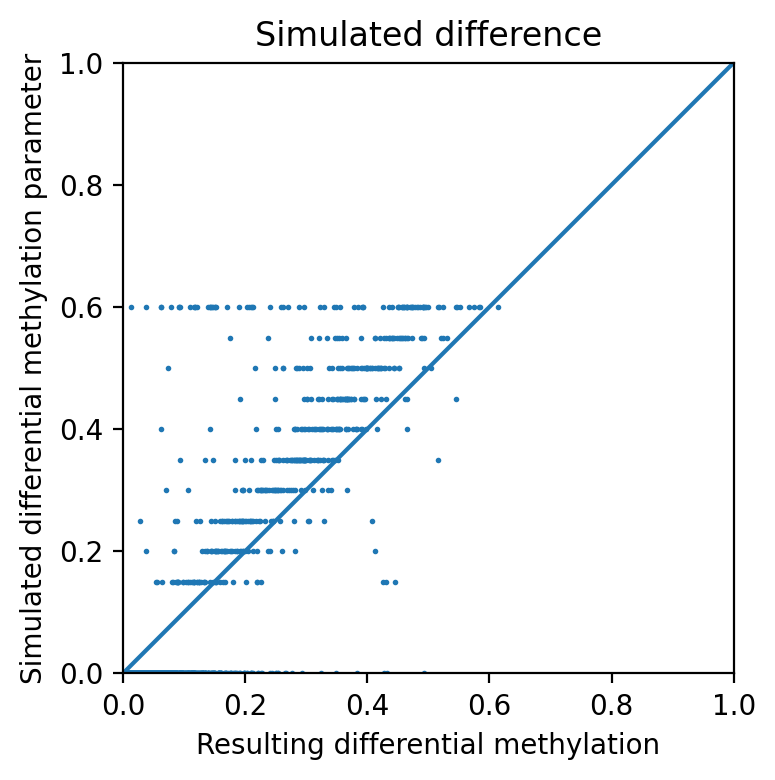

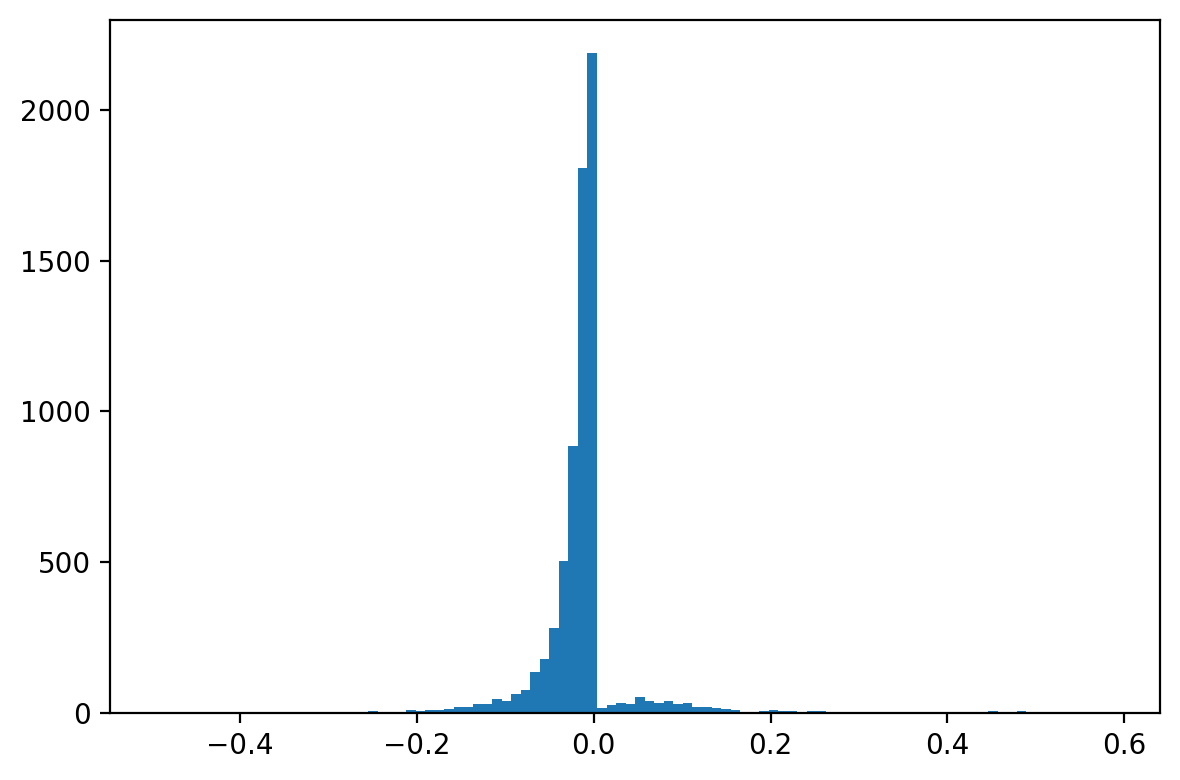

In [9]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(results.segments["GT"]["diffmet"], np.abs(results.segments["GT"]["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(results.segments["GT"]["theta"]) - results.segments["GT"]["diffmet"], bins=100)
plt.show()

In [10]:

class ResultComparer:
    def __init__(self, segments):
        self.segments = {k:v.copy() for k,v in segments.items()}

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0, pval_threshold = 1):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        if pval_threshold < 1:
            idx = idx & (ret["adj_pvalue"] < pval_threshold)

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=0.1)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold = 0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

    def compute_discovery_counts(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])

        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        return num_false_pos, num_true_pos

In [11]:

def plot_roc(gt, title="", figurename=None, tool_colors=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}

    ps = np.arange(0.001, 0.5, 0.1)
    recall = {t:[] for t in tool_colors}
    precision = {t:[] for t in tool_colors}

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    for p in ps:
        for tool in tool_colors:
            recall[tool].append(rc.compute_tpr("GT", tool, pval_threshold=p))
            precision[tool].append(1-rc.compute_fdr("GT", tool, pval_threshold=p))
    o5_index = np.argmin(np.abs((ps-0.05)))
    print(recall, precision)
    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(12,5))

    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tool_colors.items():
        ax1.plot(ps,recall[tool], label=tool, c=color)

    ax2.set_title("Precision")
    for tool, color in tool_colors.items():
        ax2.plot(ps,precision[tool], label=tool, c=color)

    for tool, color in tool_colors.items():
        auc = np.nansum(recall[tool] * np.diff(precision[tool], prepend=0))
        ax3.plot(precision[tool],recall[tool], label=f"{tool} AUC={auc:.2f}", c=color)
        ax3.scatter([precision[tool][o5_index]], [recall[tool][o5_index]], c=color)
    ax3.legend()
    ax3.set_ylabel("Recall")
    ax3.set_xlabel("Precision")

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_aspect("equal")
    plt.tight_layout()
    pa.saveandshow(figurename)



def plot_measures(gt, title="", figurename=None, tool_colors=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}

    recall = []
    precision = []
    f1 = []

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")


    for tool in tool_colors:
        p = 1-rc.compute_fdr("GT", tool, pval_threshold=0.05)
        r = rc.compute_tpr("GT", tool, pval_threshold=0.05)
        f = 2*(p*r)/(p+r)

        recall.append(r)
        precision.append(p)
        f1.append(f)

    pa.figure(figsize=(16,8))
    plt.title(title)
    x = 0
    for y, (tool, color) in zip(recall, tool_colors.items()):
        plt.bar(x,y, width=1, color=color)
        x+=1

    x+=1
    for y, (tool, color) in zip(precision, tool_colors.items()):
        plt.bar(x,y, width=1, color=color)
        x+=1

    x+=1
    for y, (tool, color) in zip(f1, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, label=tool)
        x+=1

    plt.xticks(np.arange(len(tool_colors)/2, len(tool_colors)*3, len(tool_colors)+1), ["Recall", "Precision", "F1-score"])

    plt.legend(loc=(1.04,0))
    plt.ylim(0.5,1)
    plt.tight_layout()
    pa.saveandshow(figurename)

def plot_roc_over_effect_size(gt, title="", figurename=None, tool_colors=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    ess = np.arange(0.1, 1.05, 0.075)
    recall = {t:[] for t in tool_colors}
    precision = {t:[] for t in tool_colors}
    f1 = {t:[] for t in tool_colors}
    for es in ess:
        for tool in tool_colors:
            r = rc.compute_tpr("GT", tool, theta_threshold=es, pval_threshold=0.05)
            p = 1-rc.compute_fdr("GT", tool, diffmet_threshold=es, pval_threshold=0.05)
            if p+r > 0:
                f = 2*(p*r)/(p+r)
            else:
                f = np.nan
            recall[tool].append(r)
            precision[tool].append(p)
            f1[tool].append(f)

    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(16, 8))
    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tool_colors.items():
        ax1.plot(ess,recall[tool], label=tool, c=color)
    ax1.set_ylabel("Recall")

    ax2.set_title("Precision")
    for tool, color in tool_colors.items():
        ax2.plot(ess,precision[tool], label=tool, c=color)
        ax2.set_ylabel("Precision")

    ax3.set_title("F1-score")
    for tool, color in tool_colors.items():
        ax3.plot(ess,f1[tool], label=tool, c=color)
    ax3.set_ylabel("F1-score")
    ax3.legend()

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0.5,1)
        ax.set_aspect("equal")
        ax.set_xlabel("Effect size")
    pa.saveandshow(figurename)

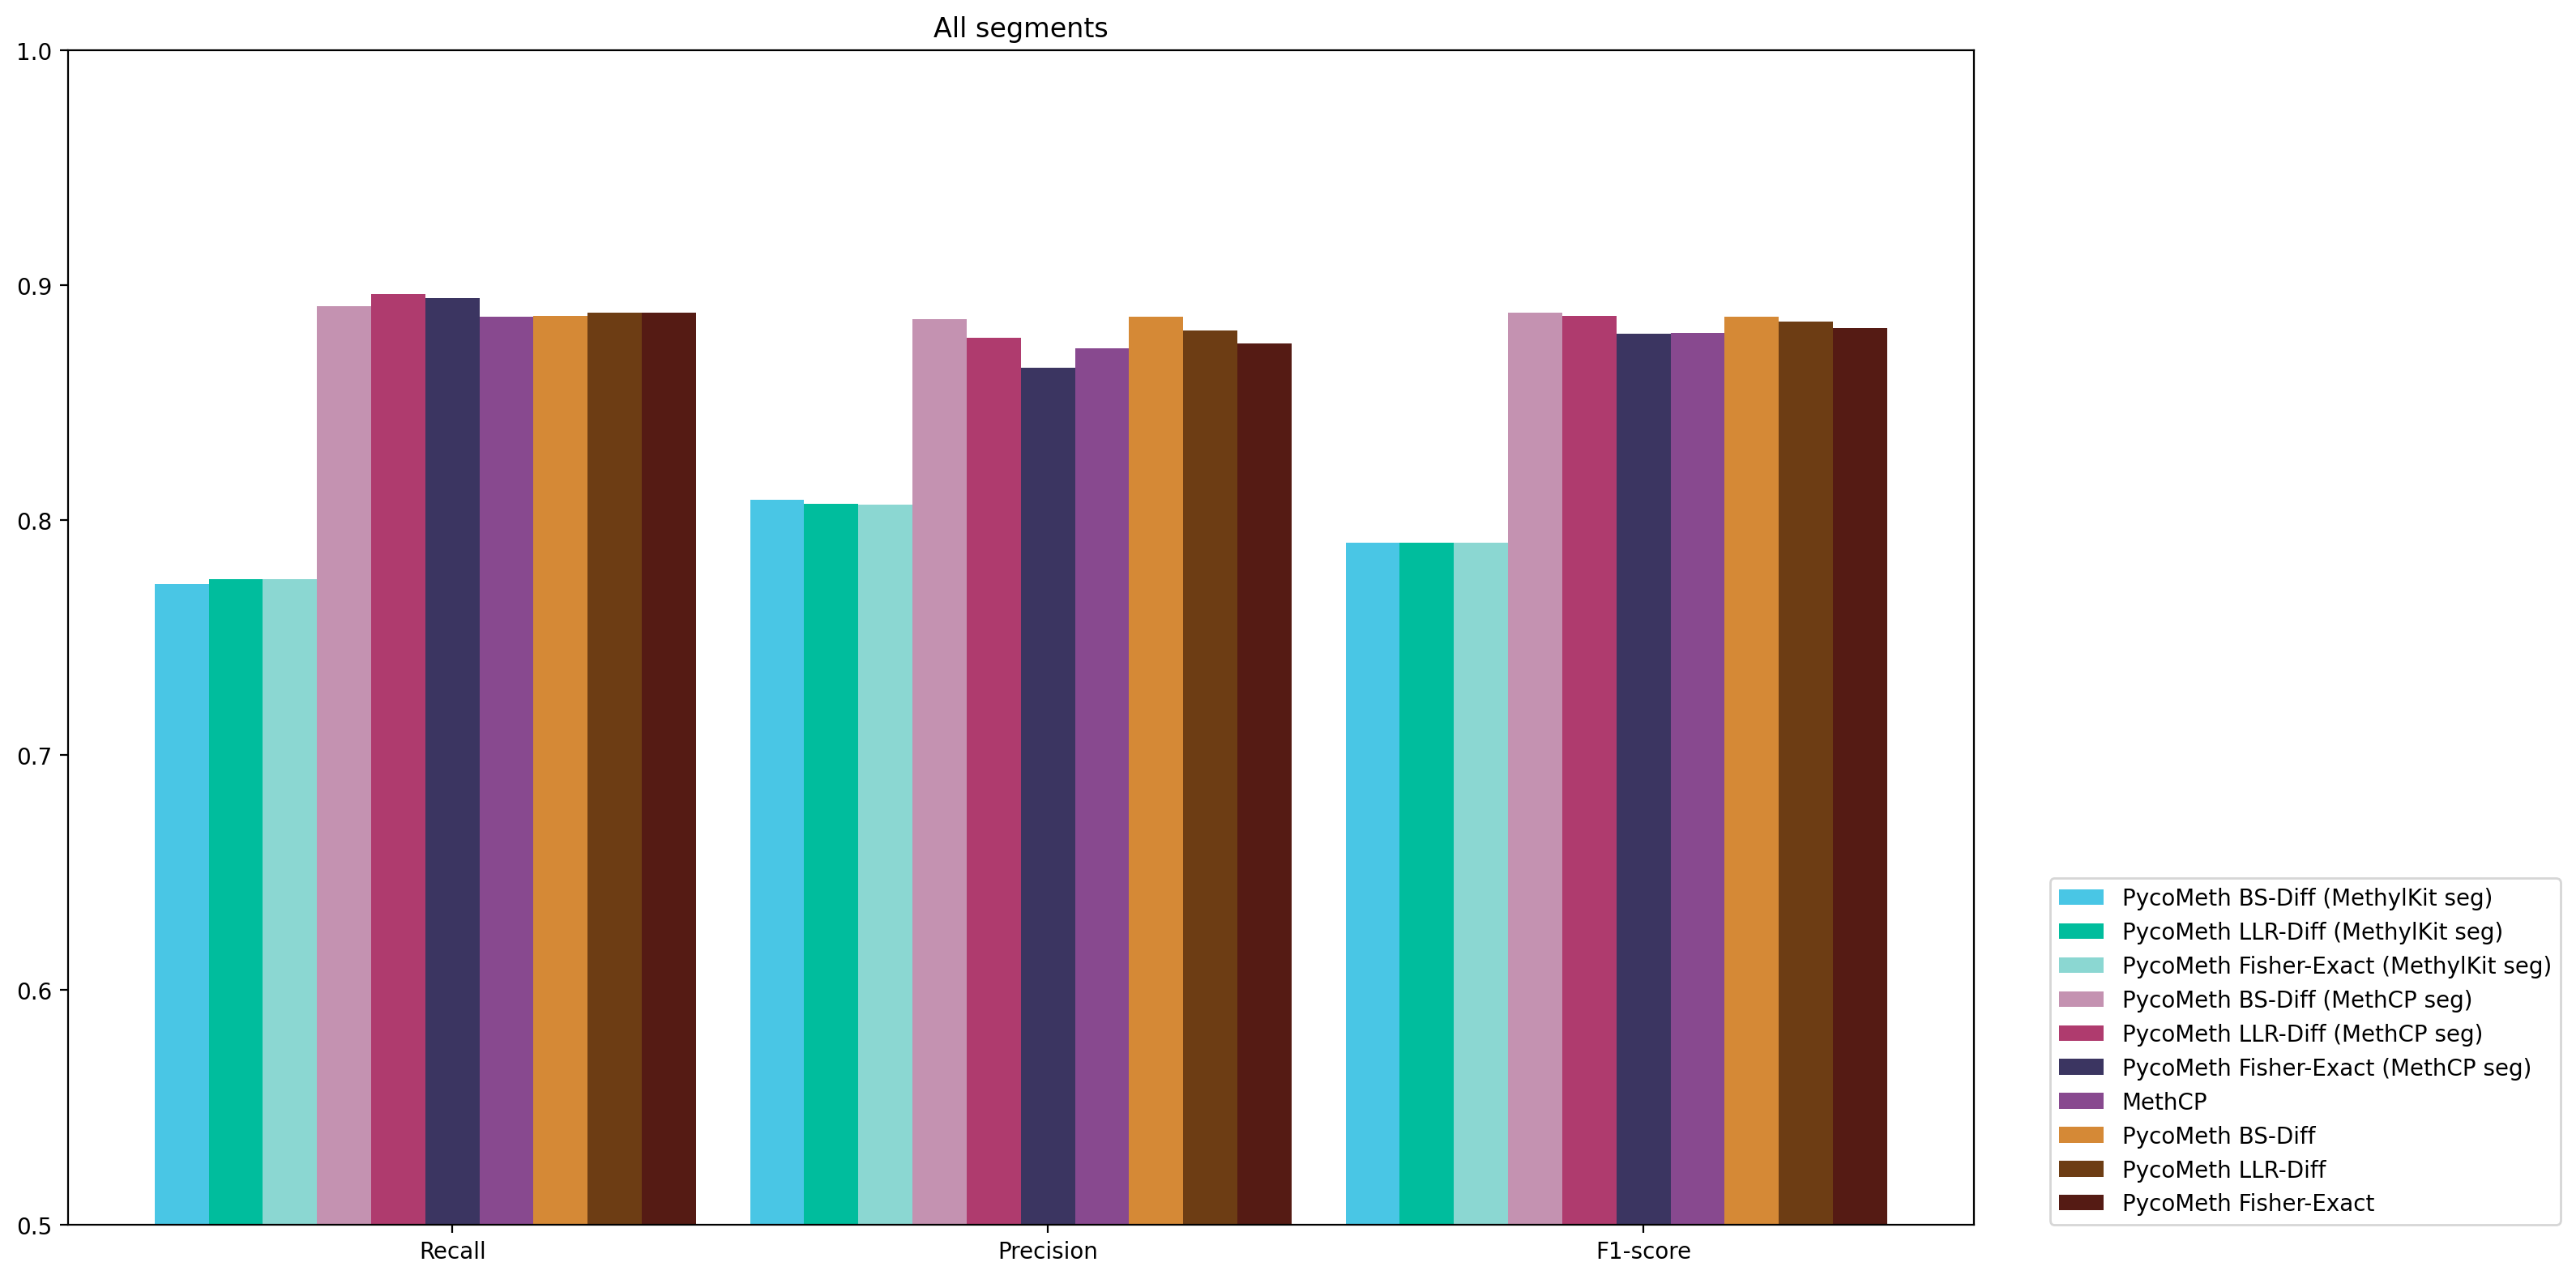

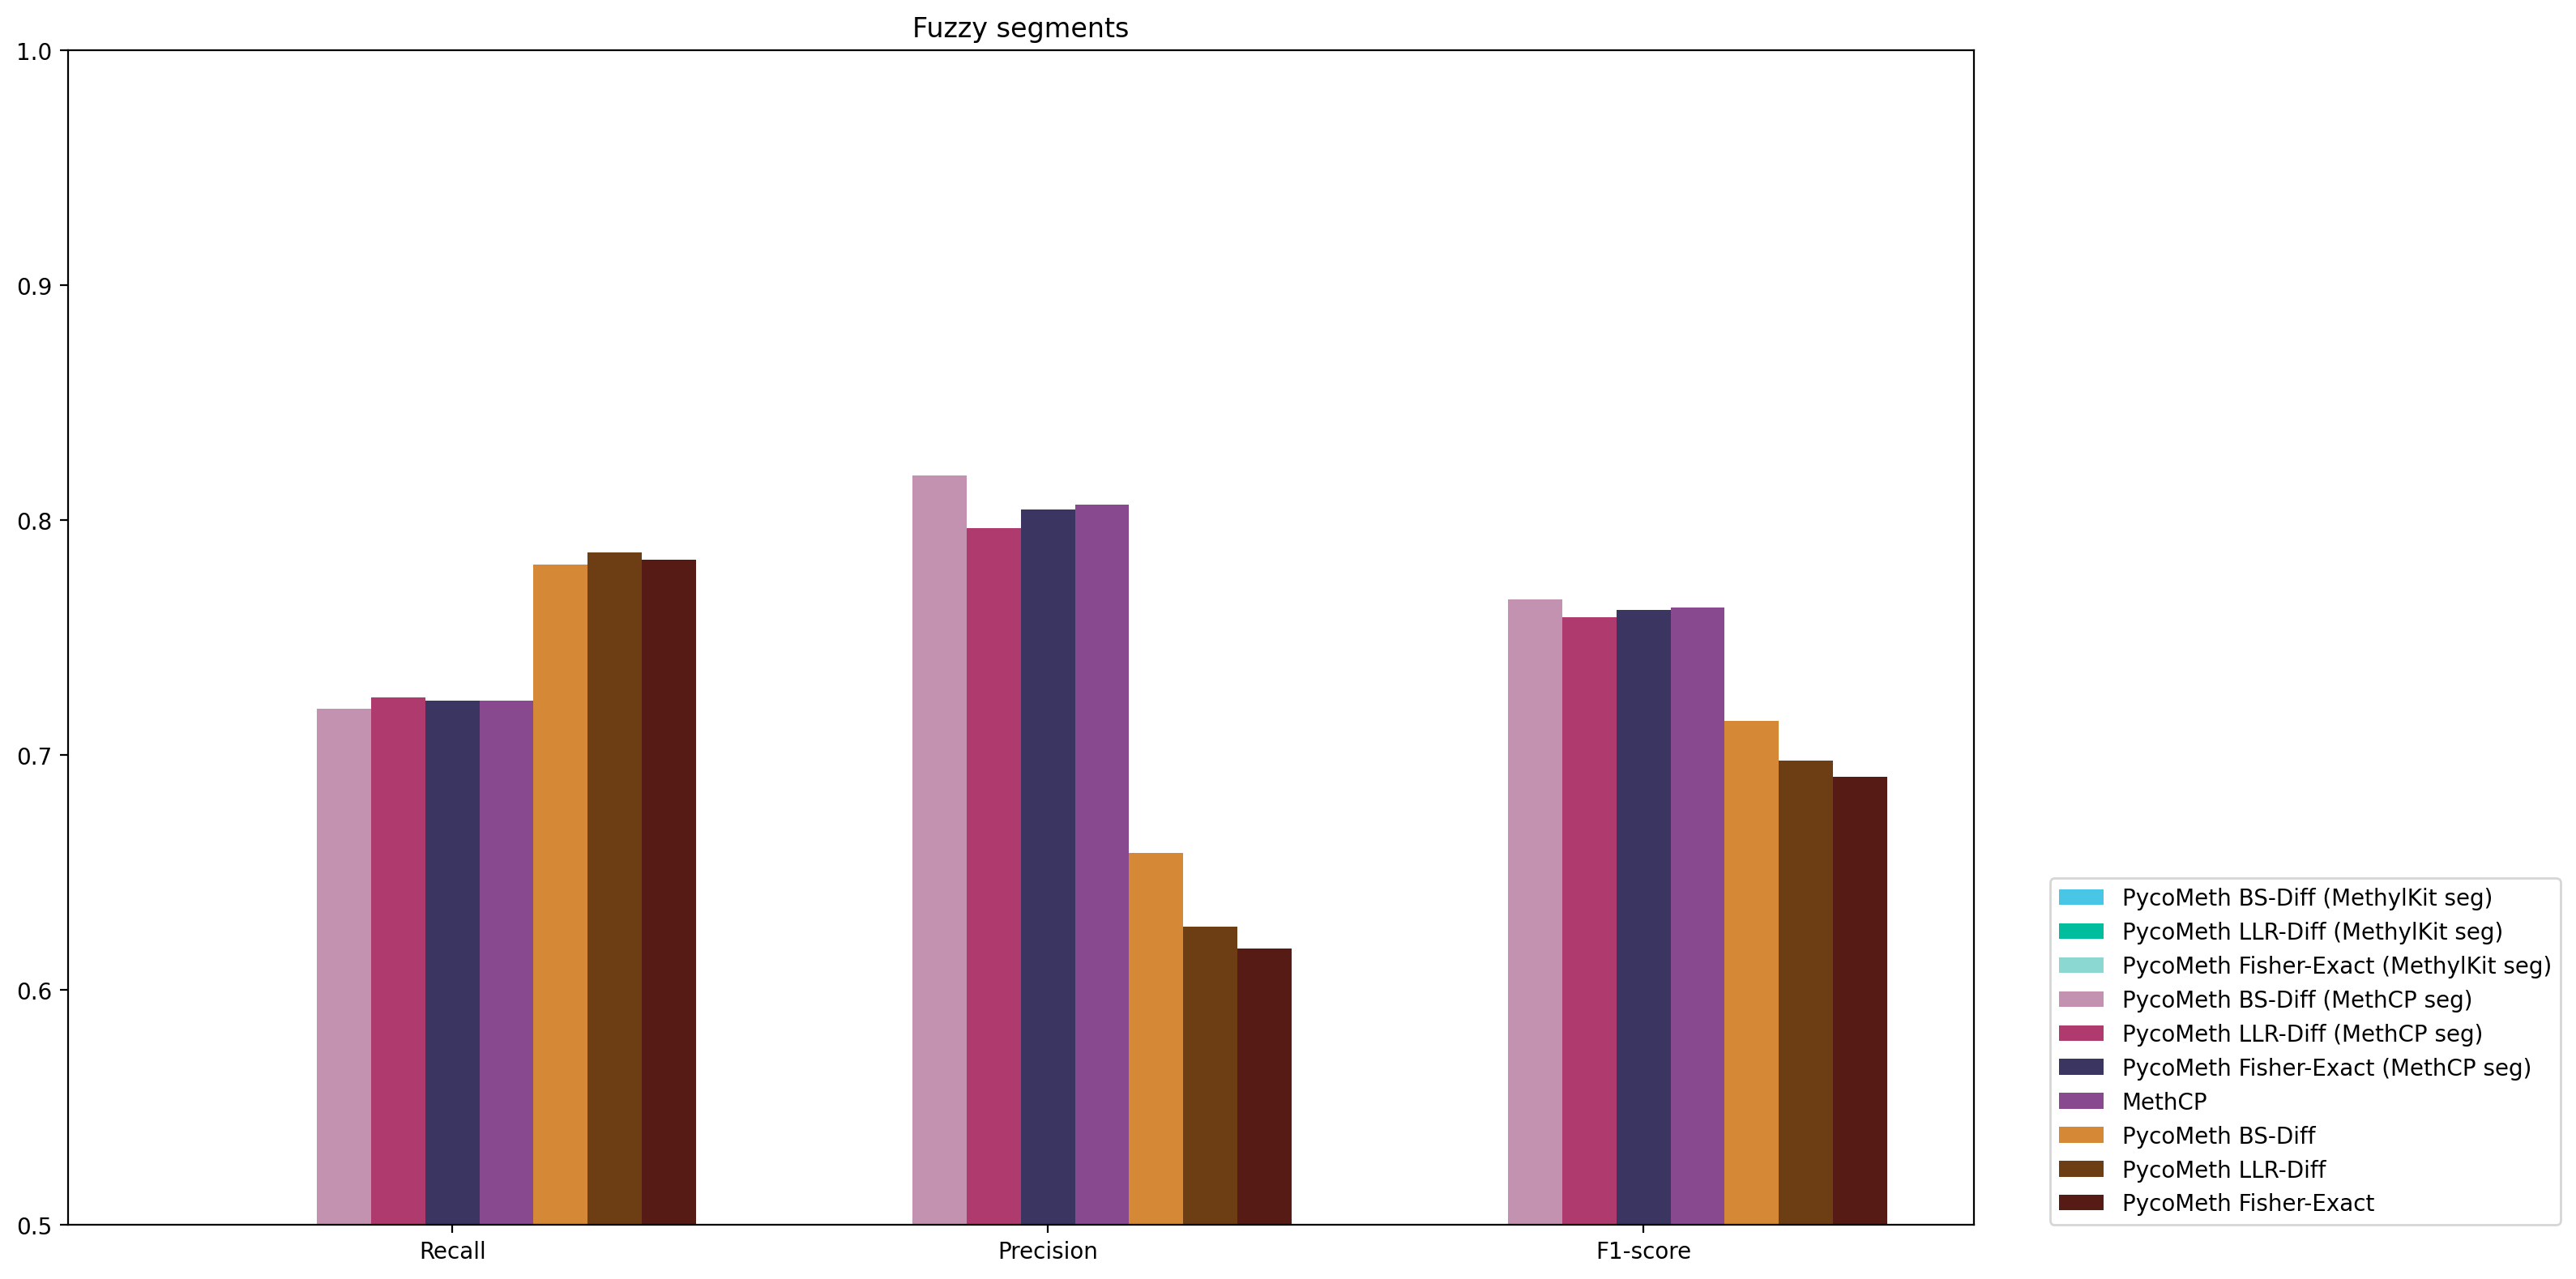

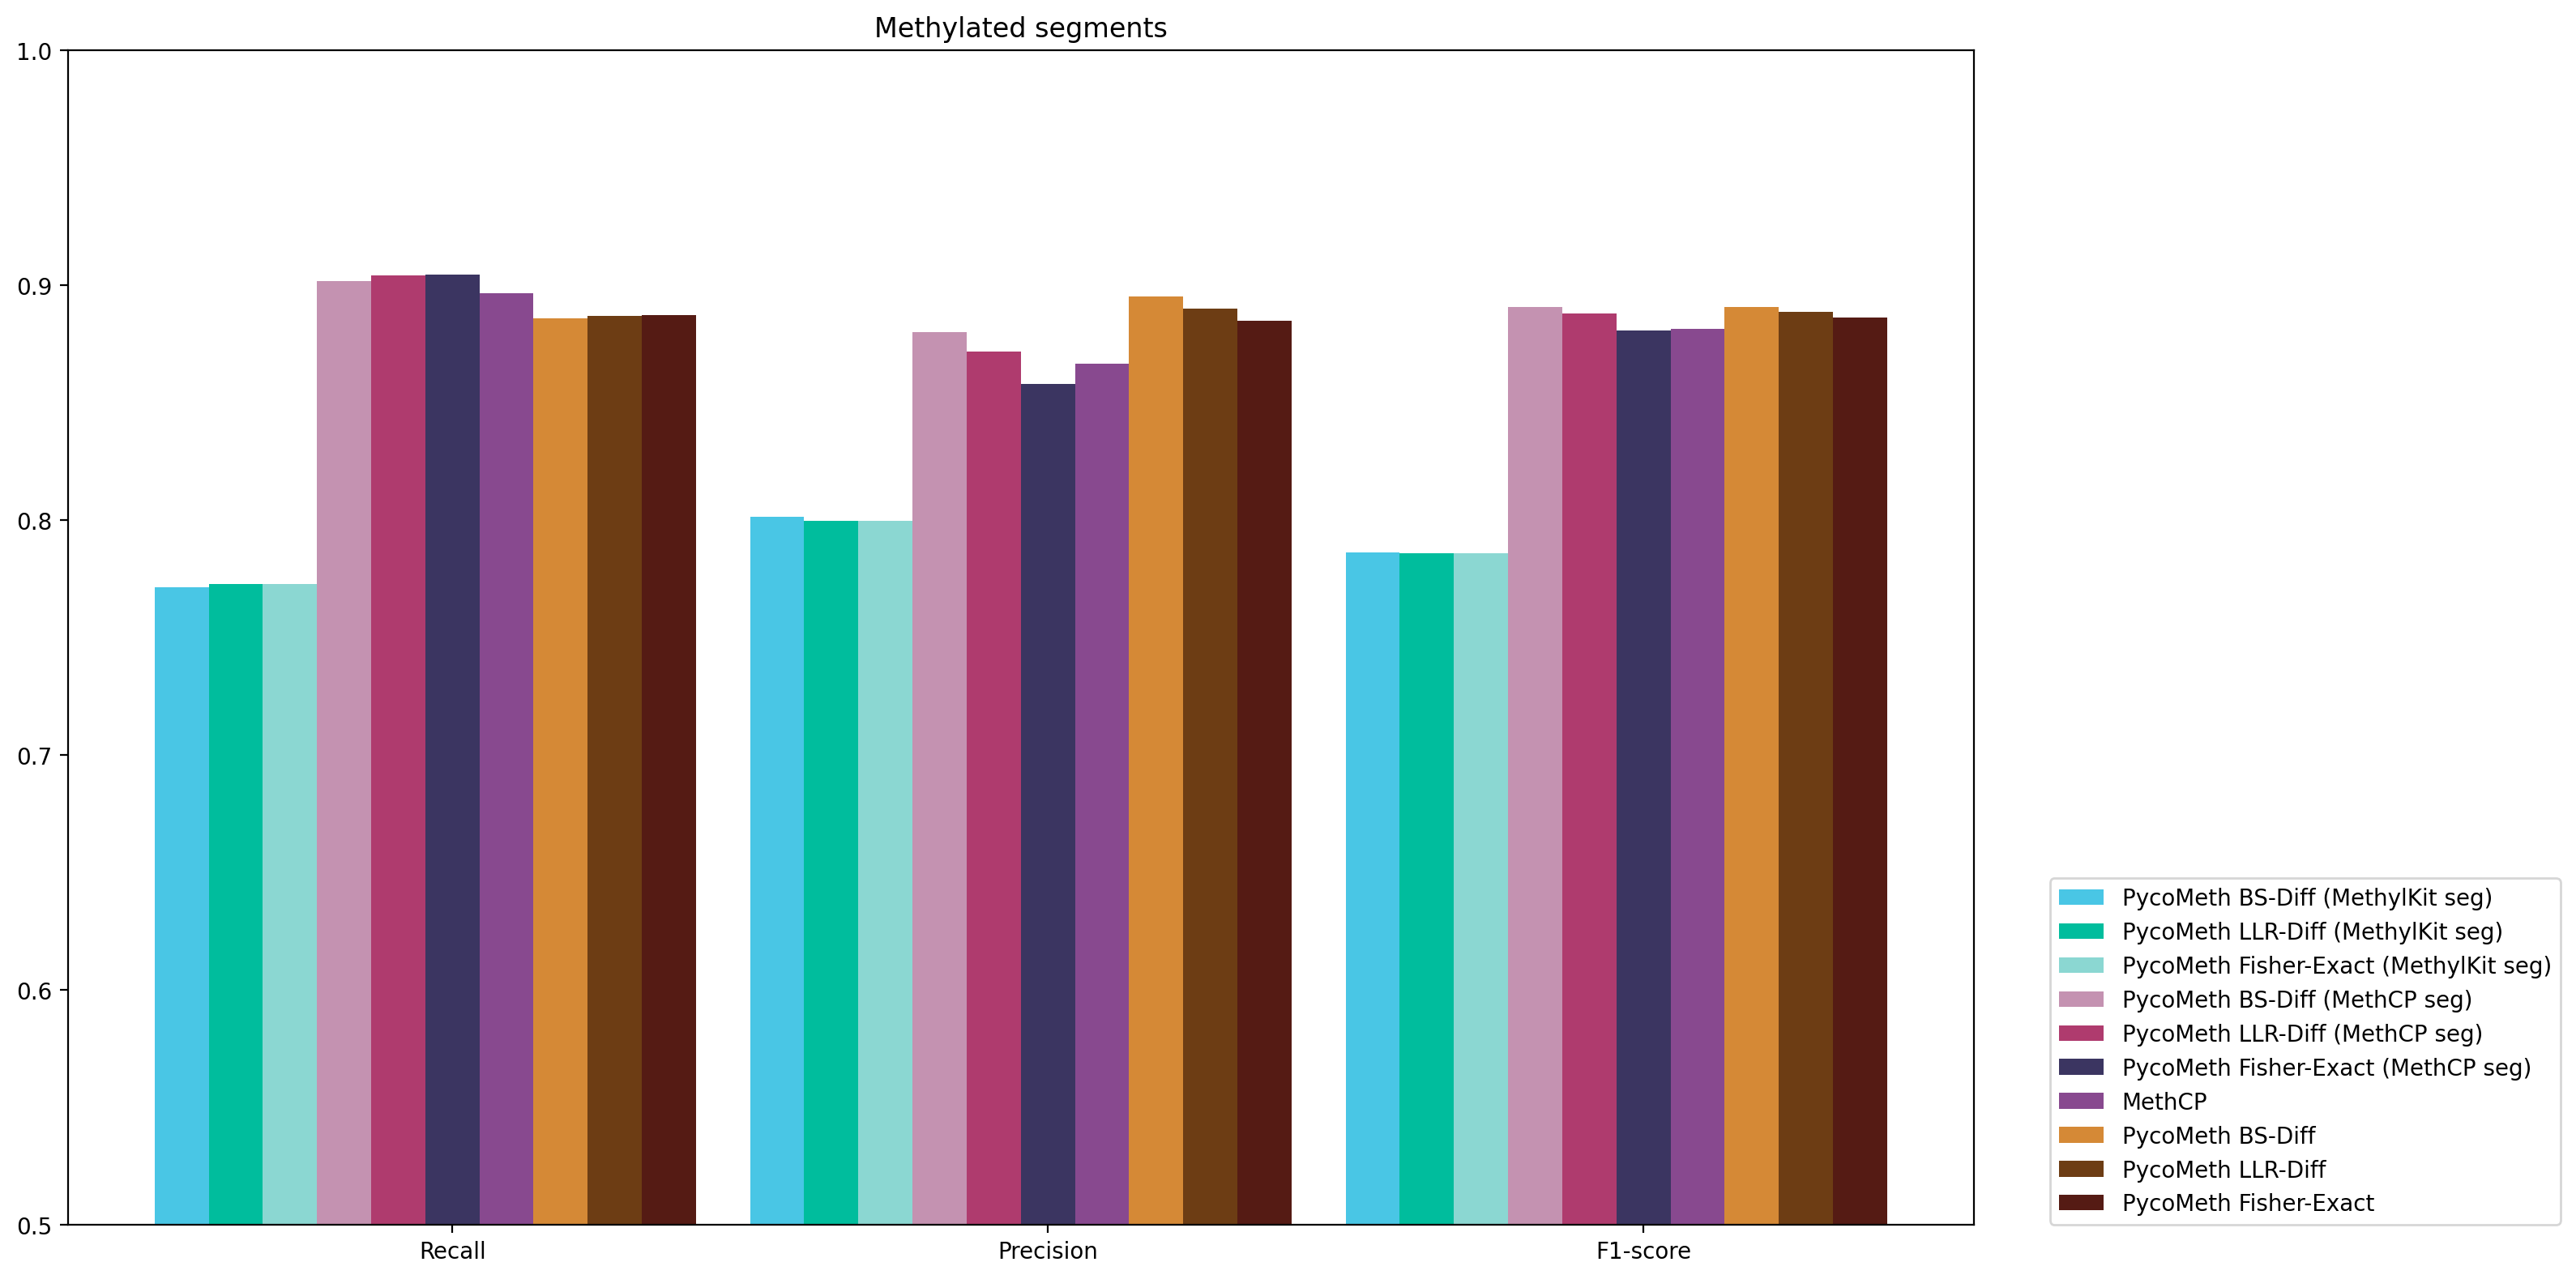

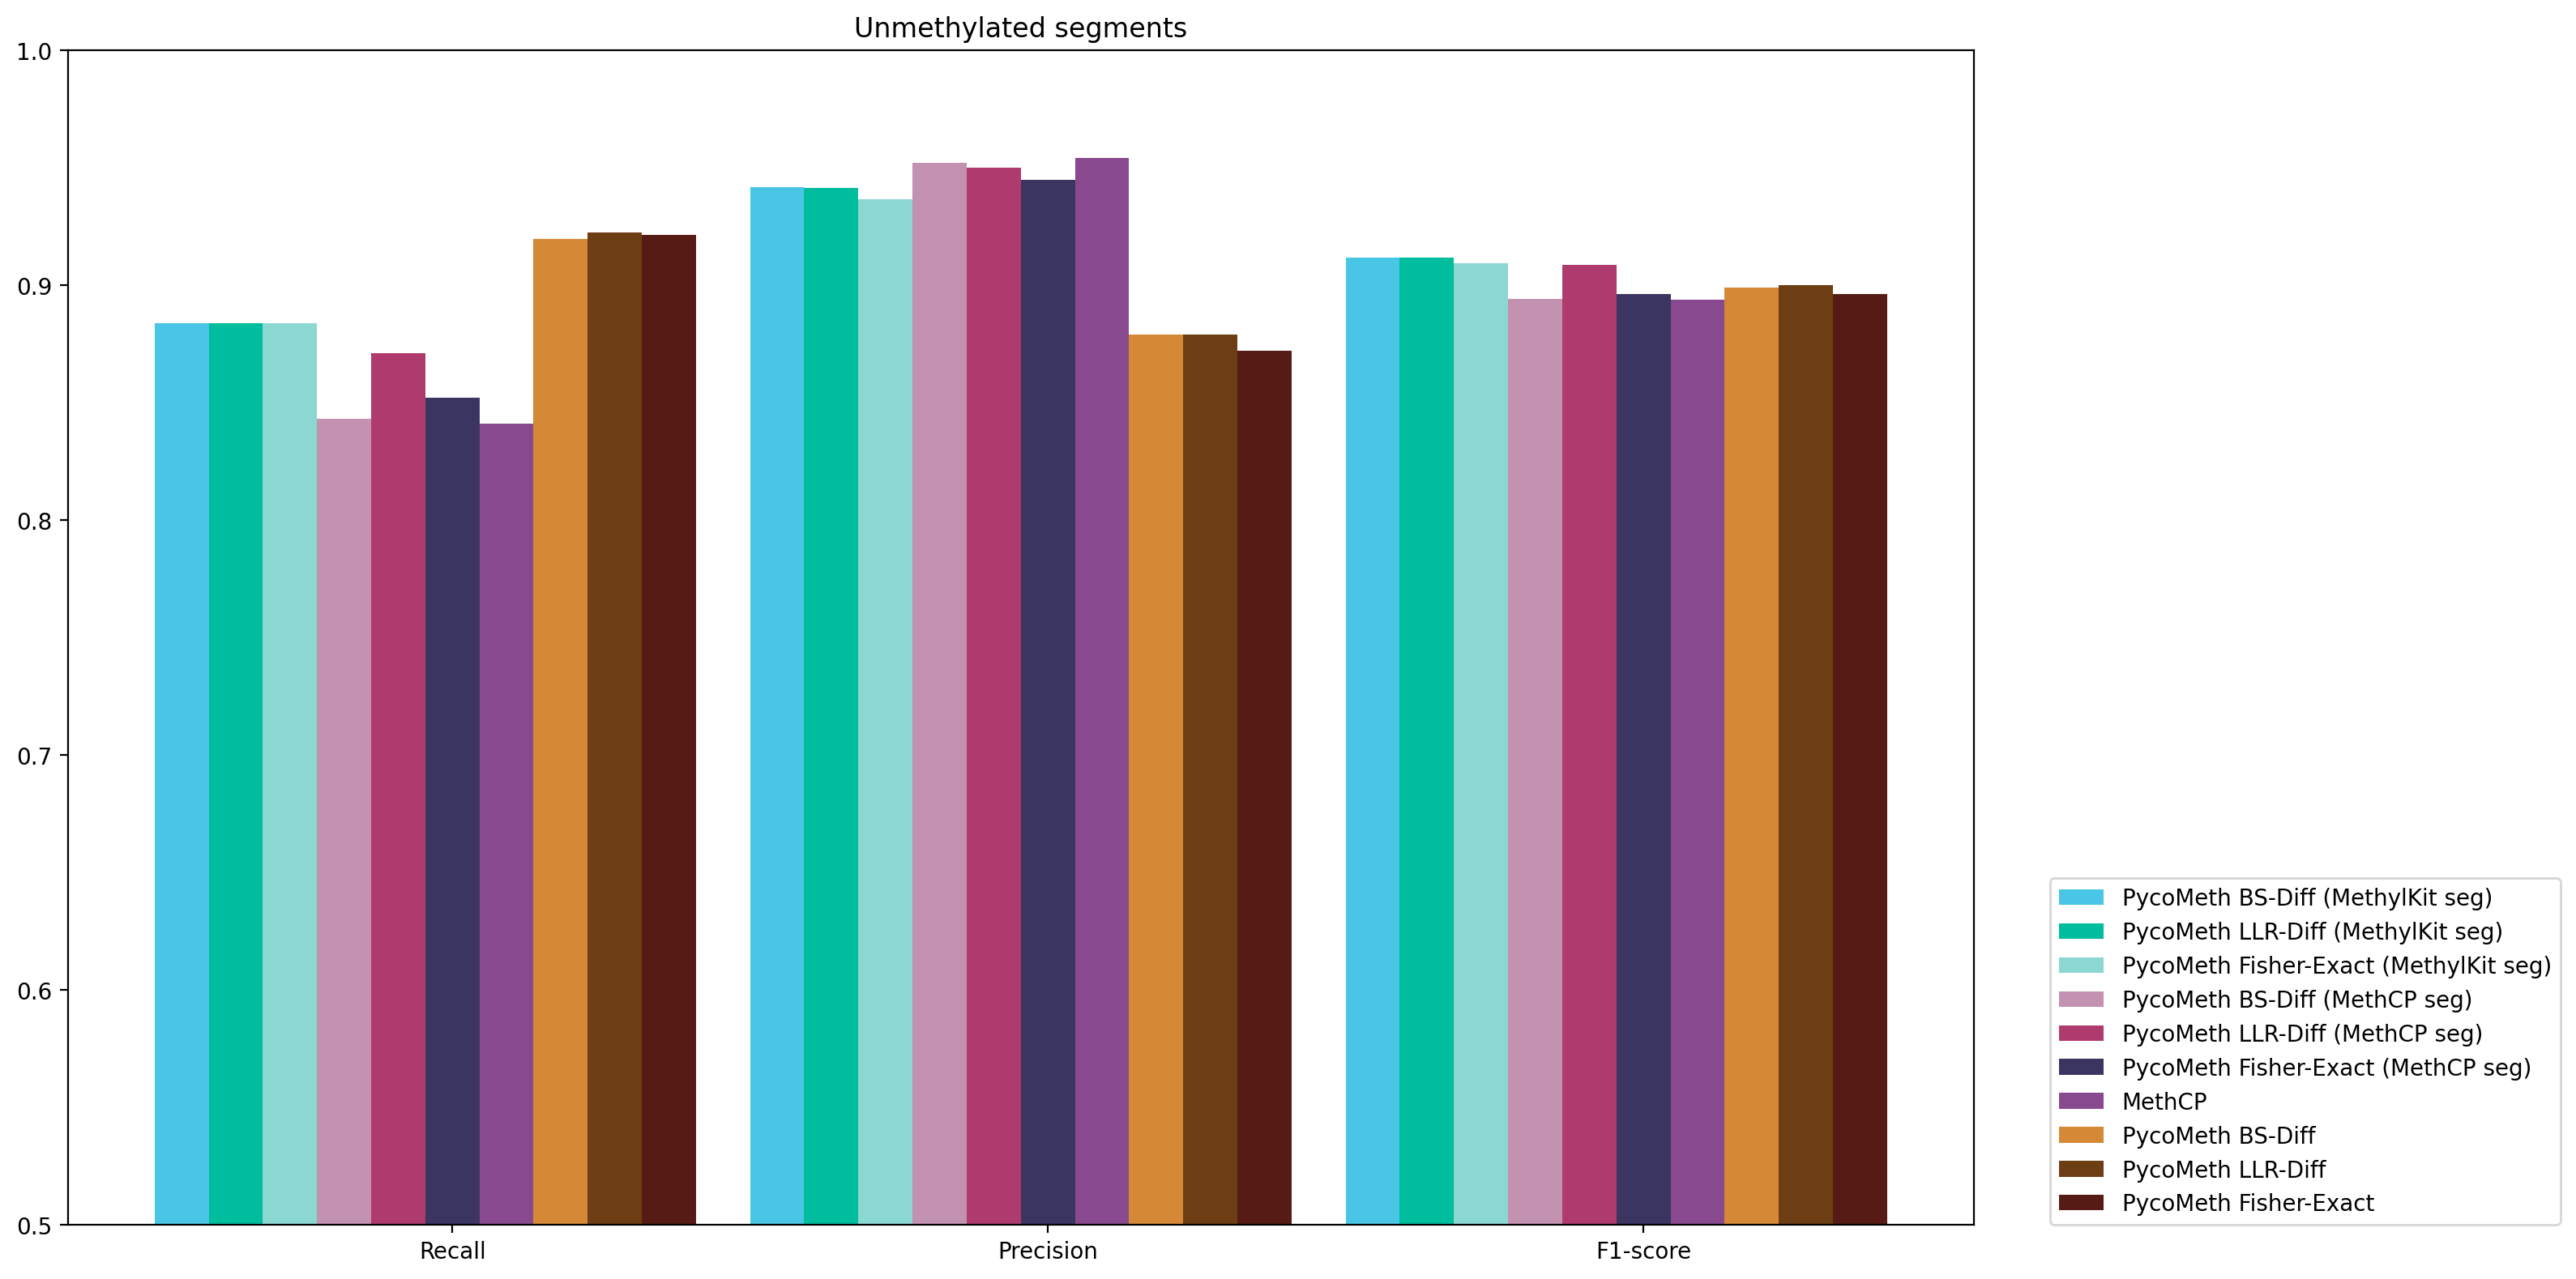

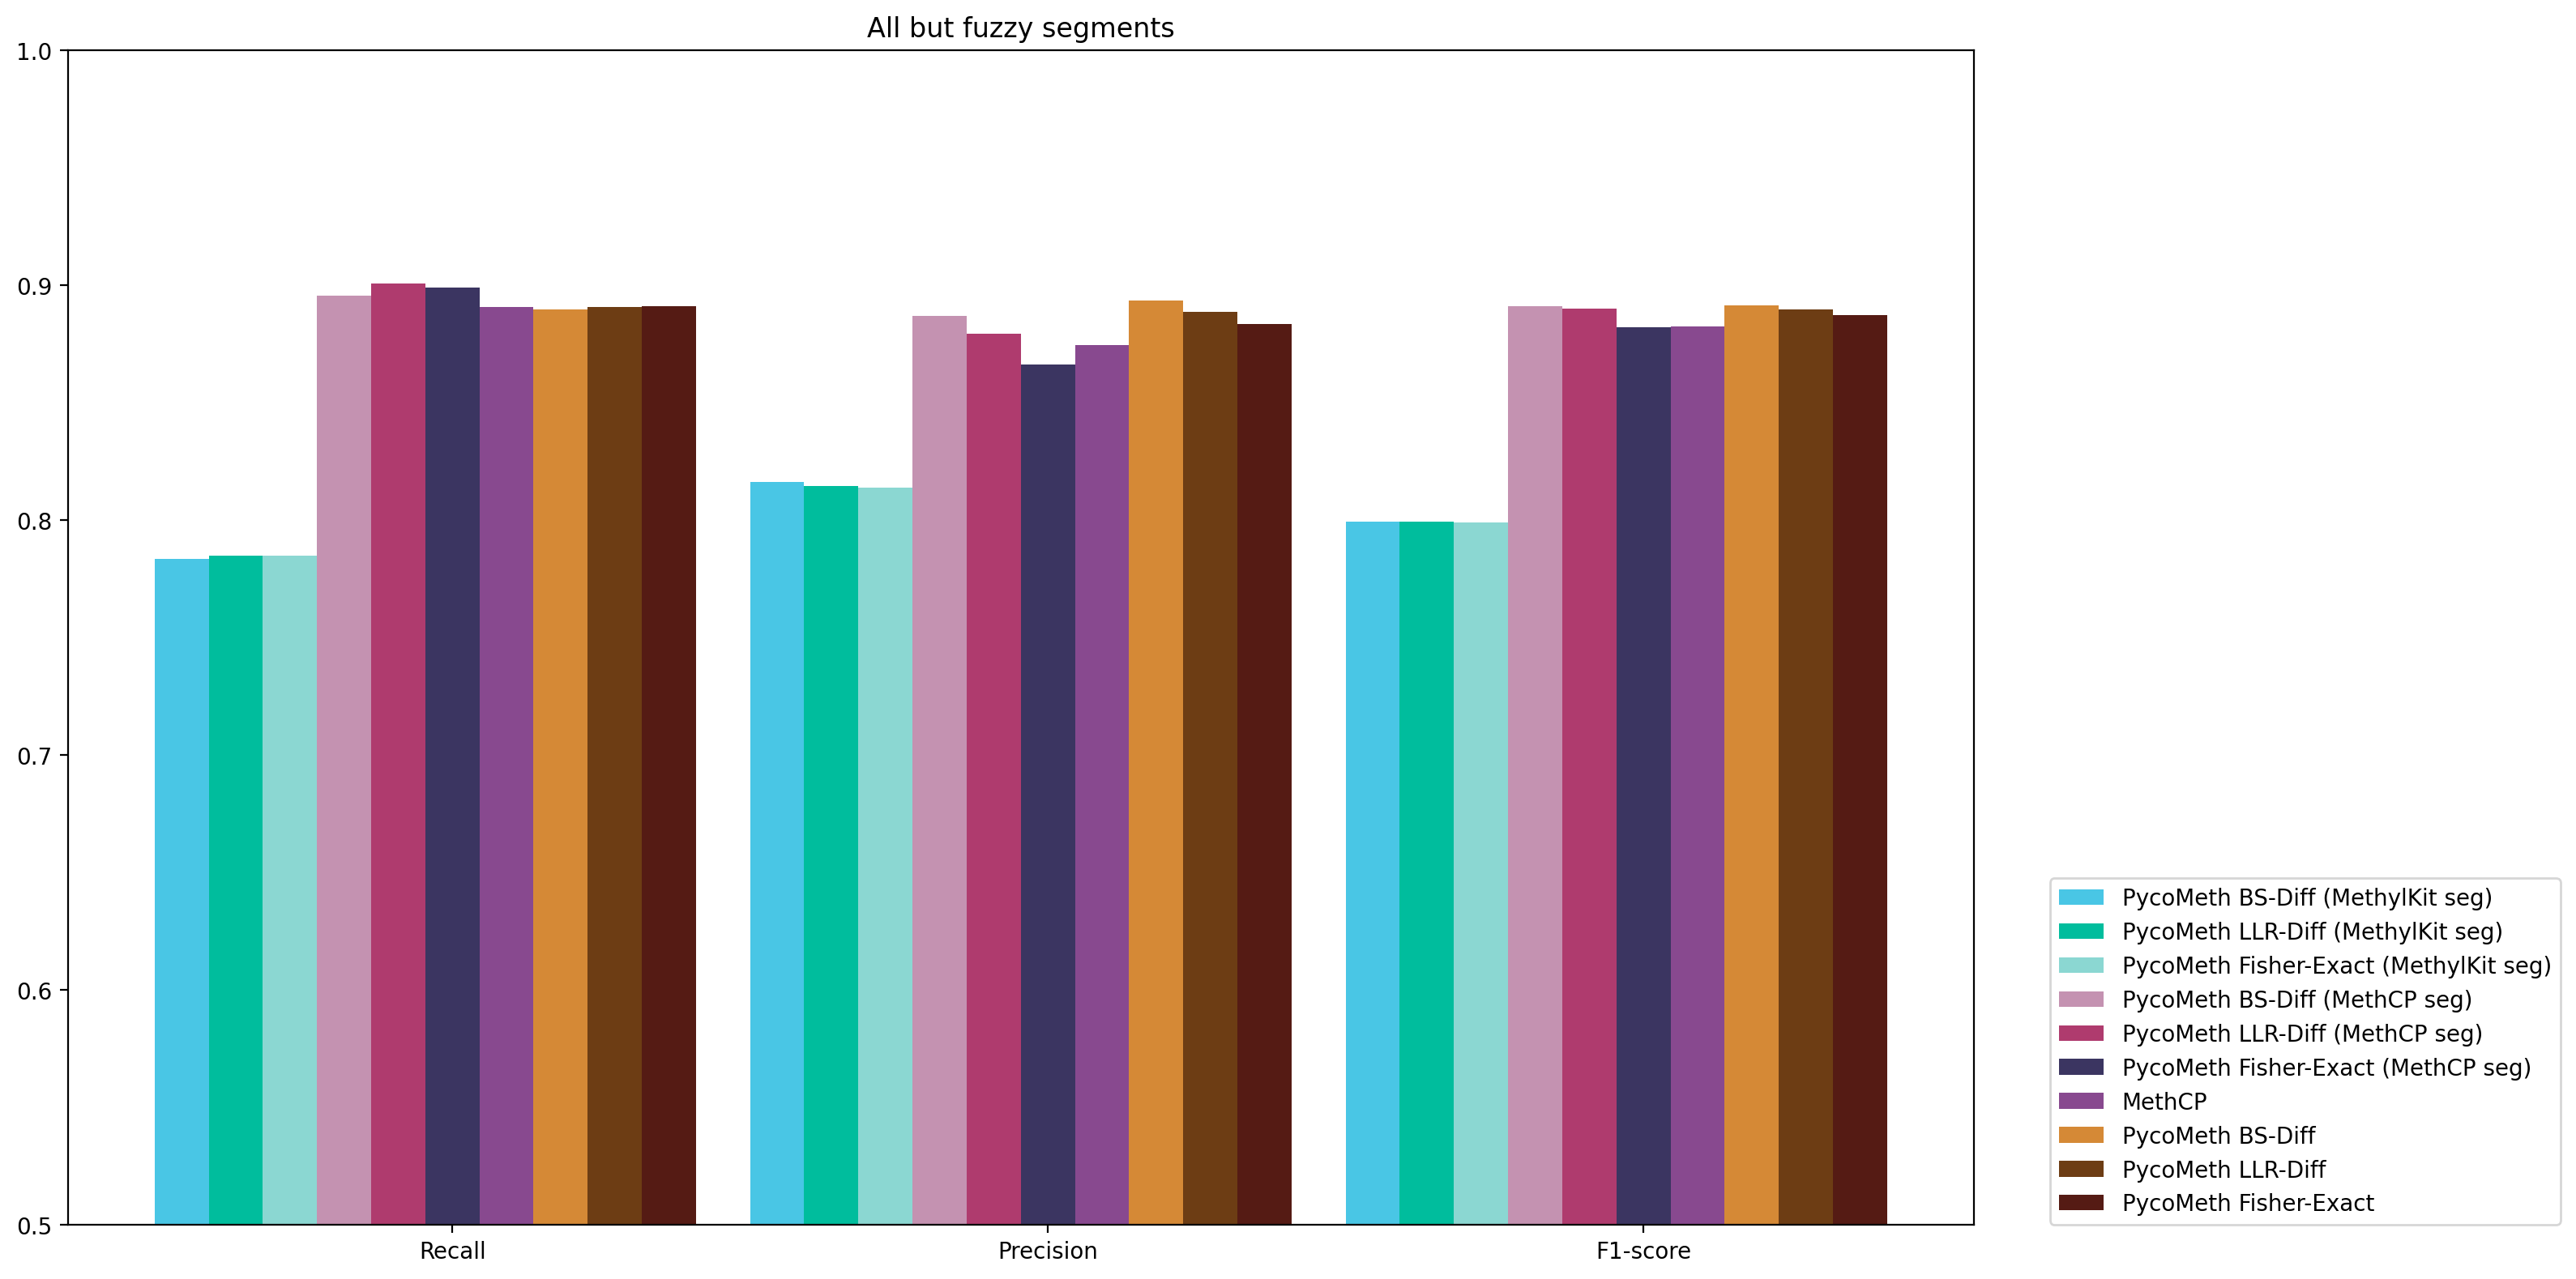

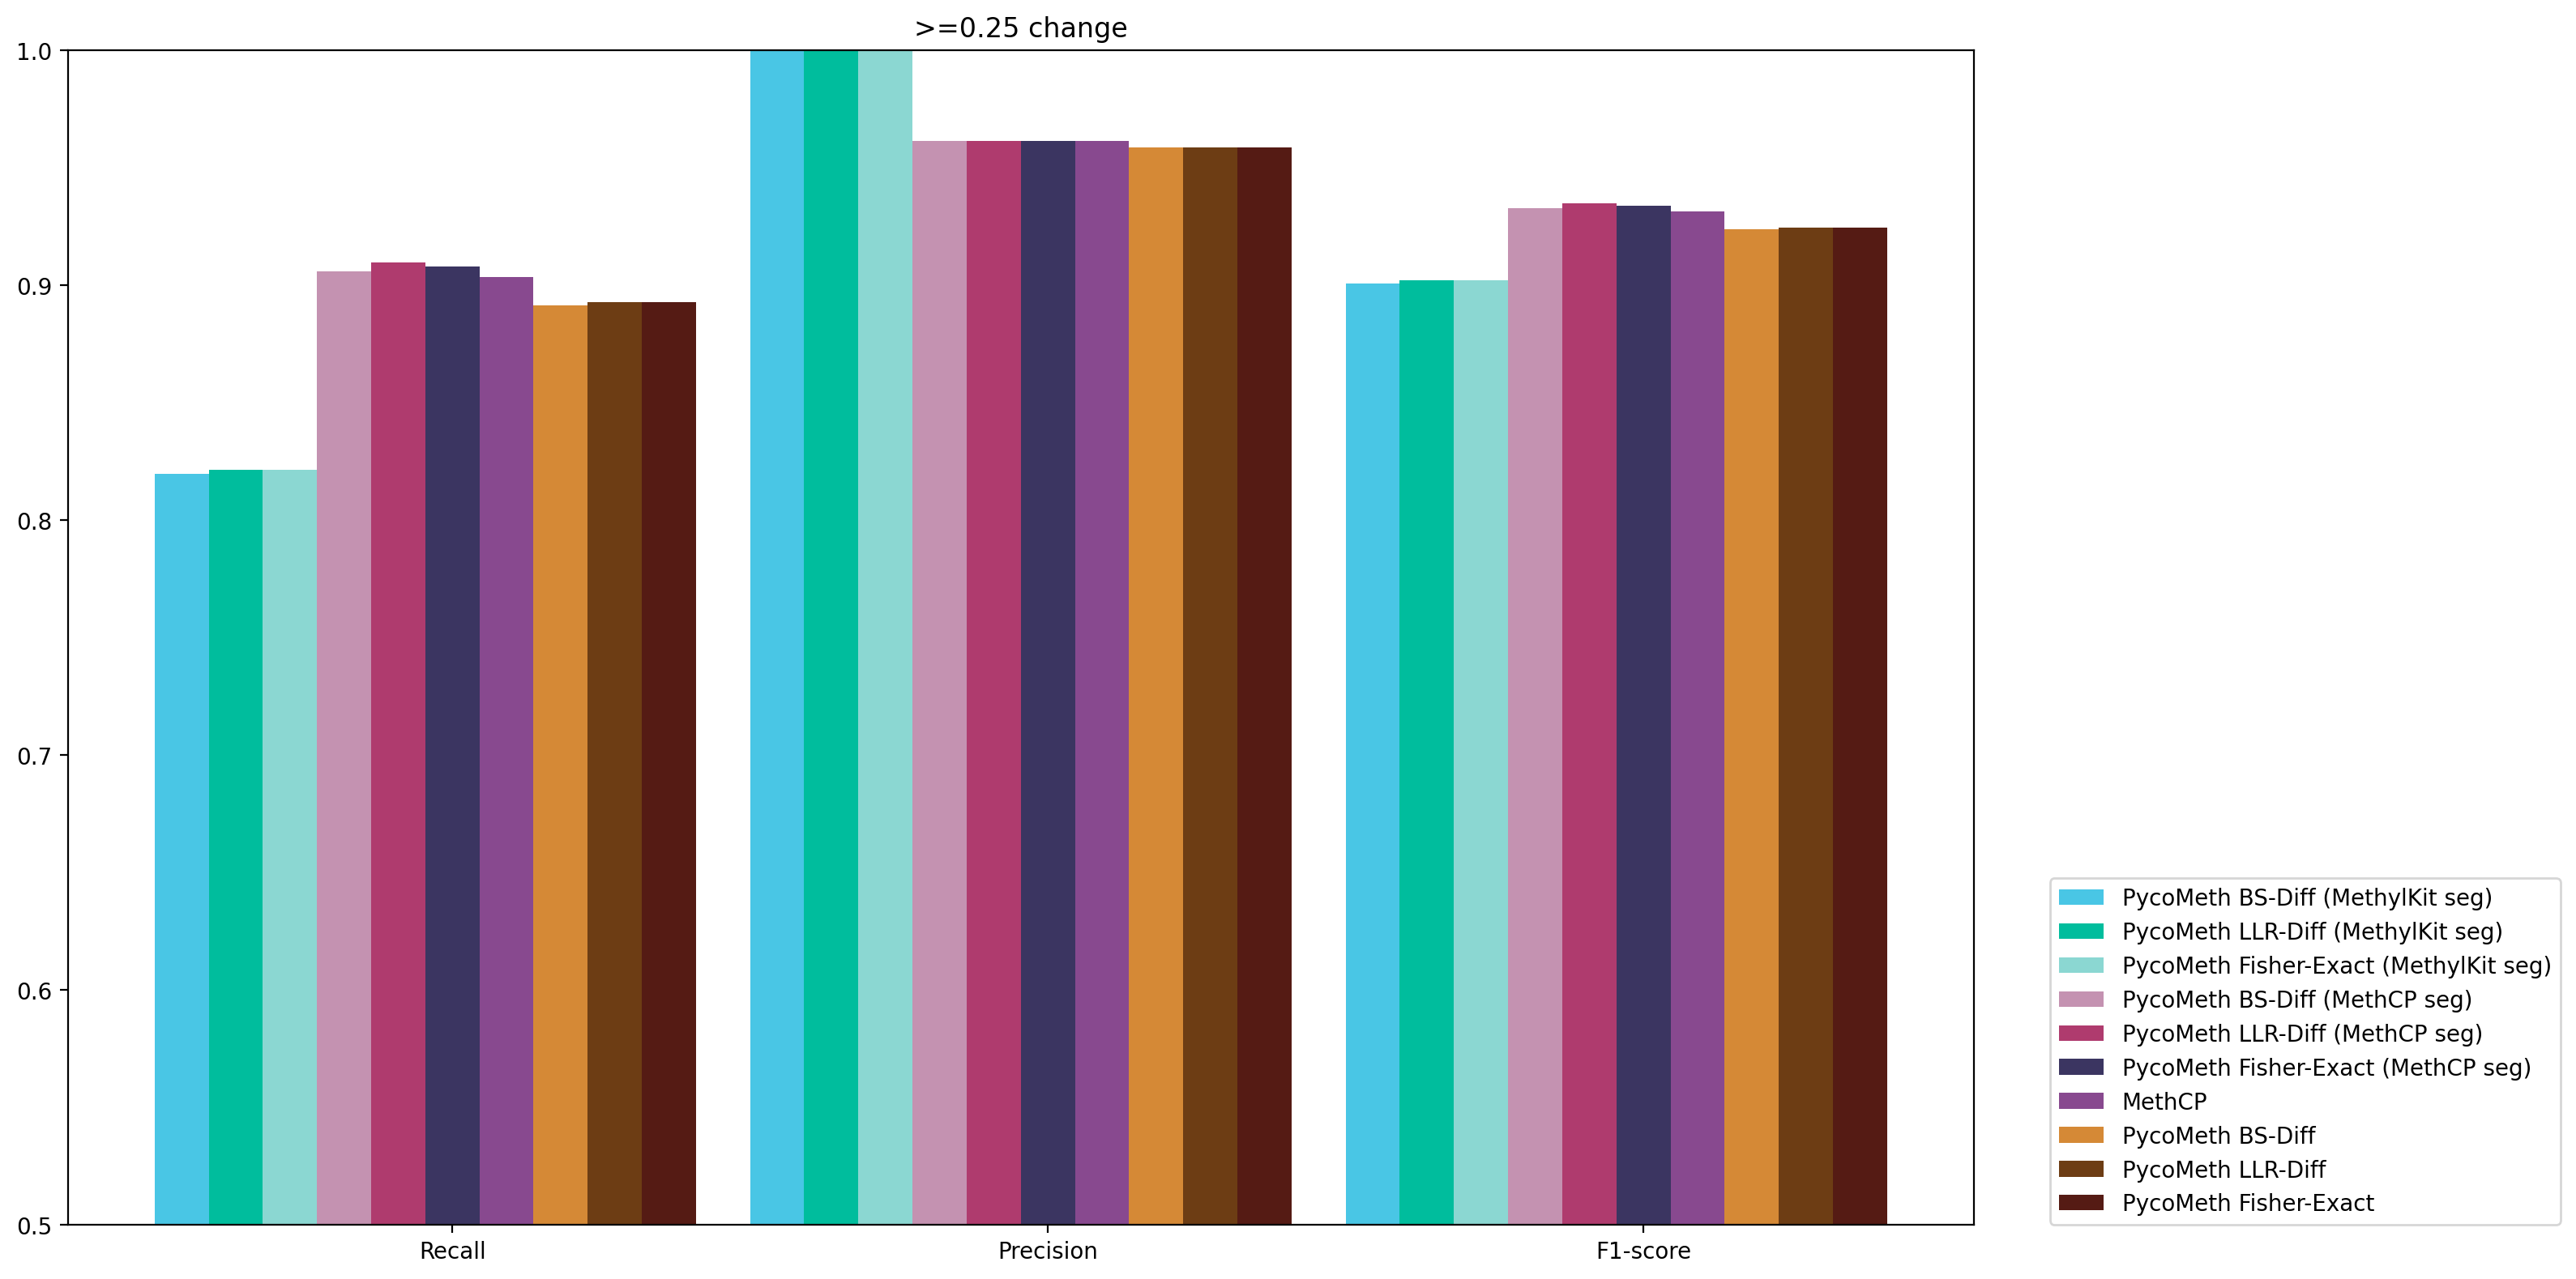

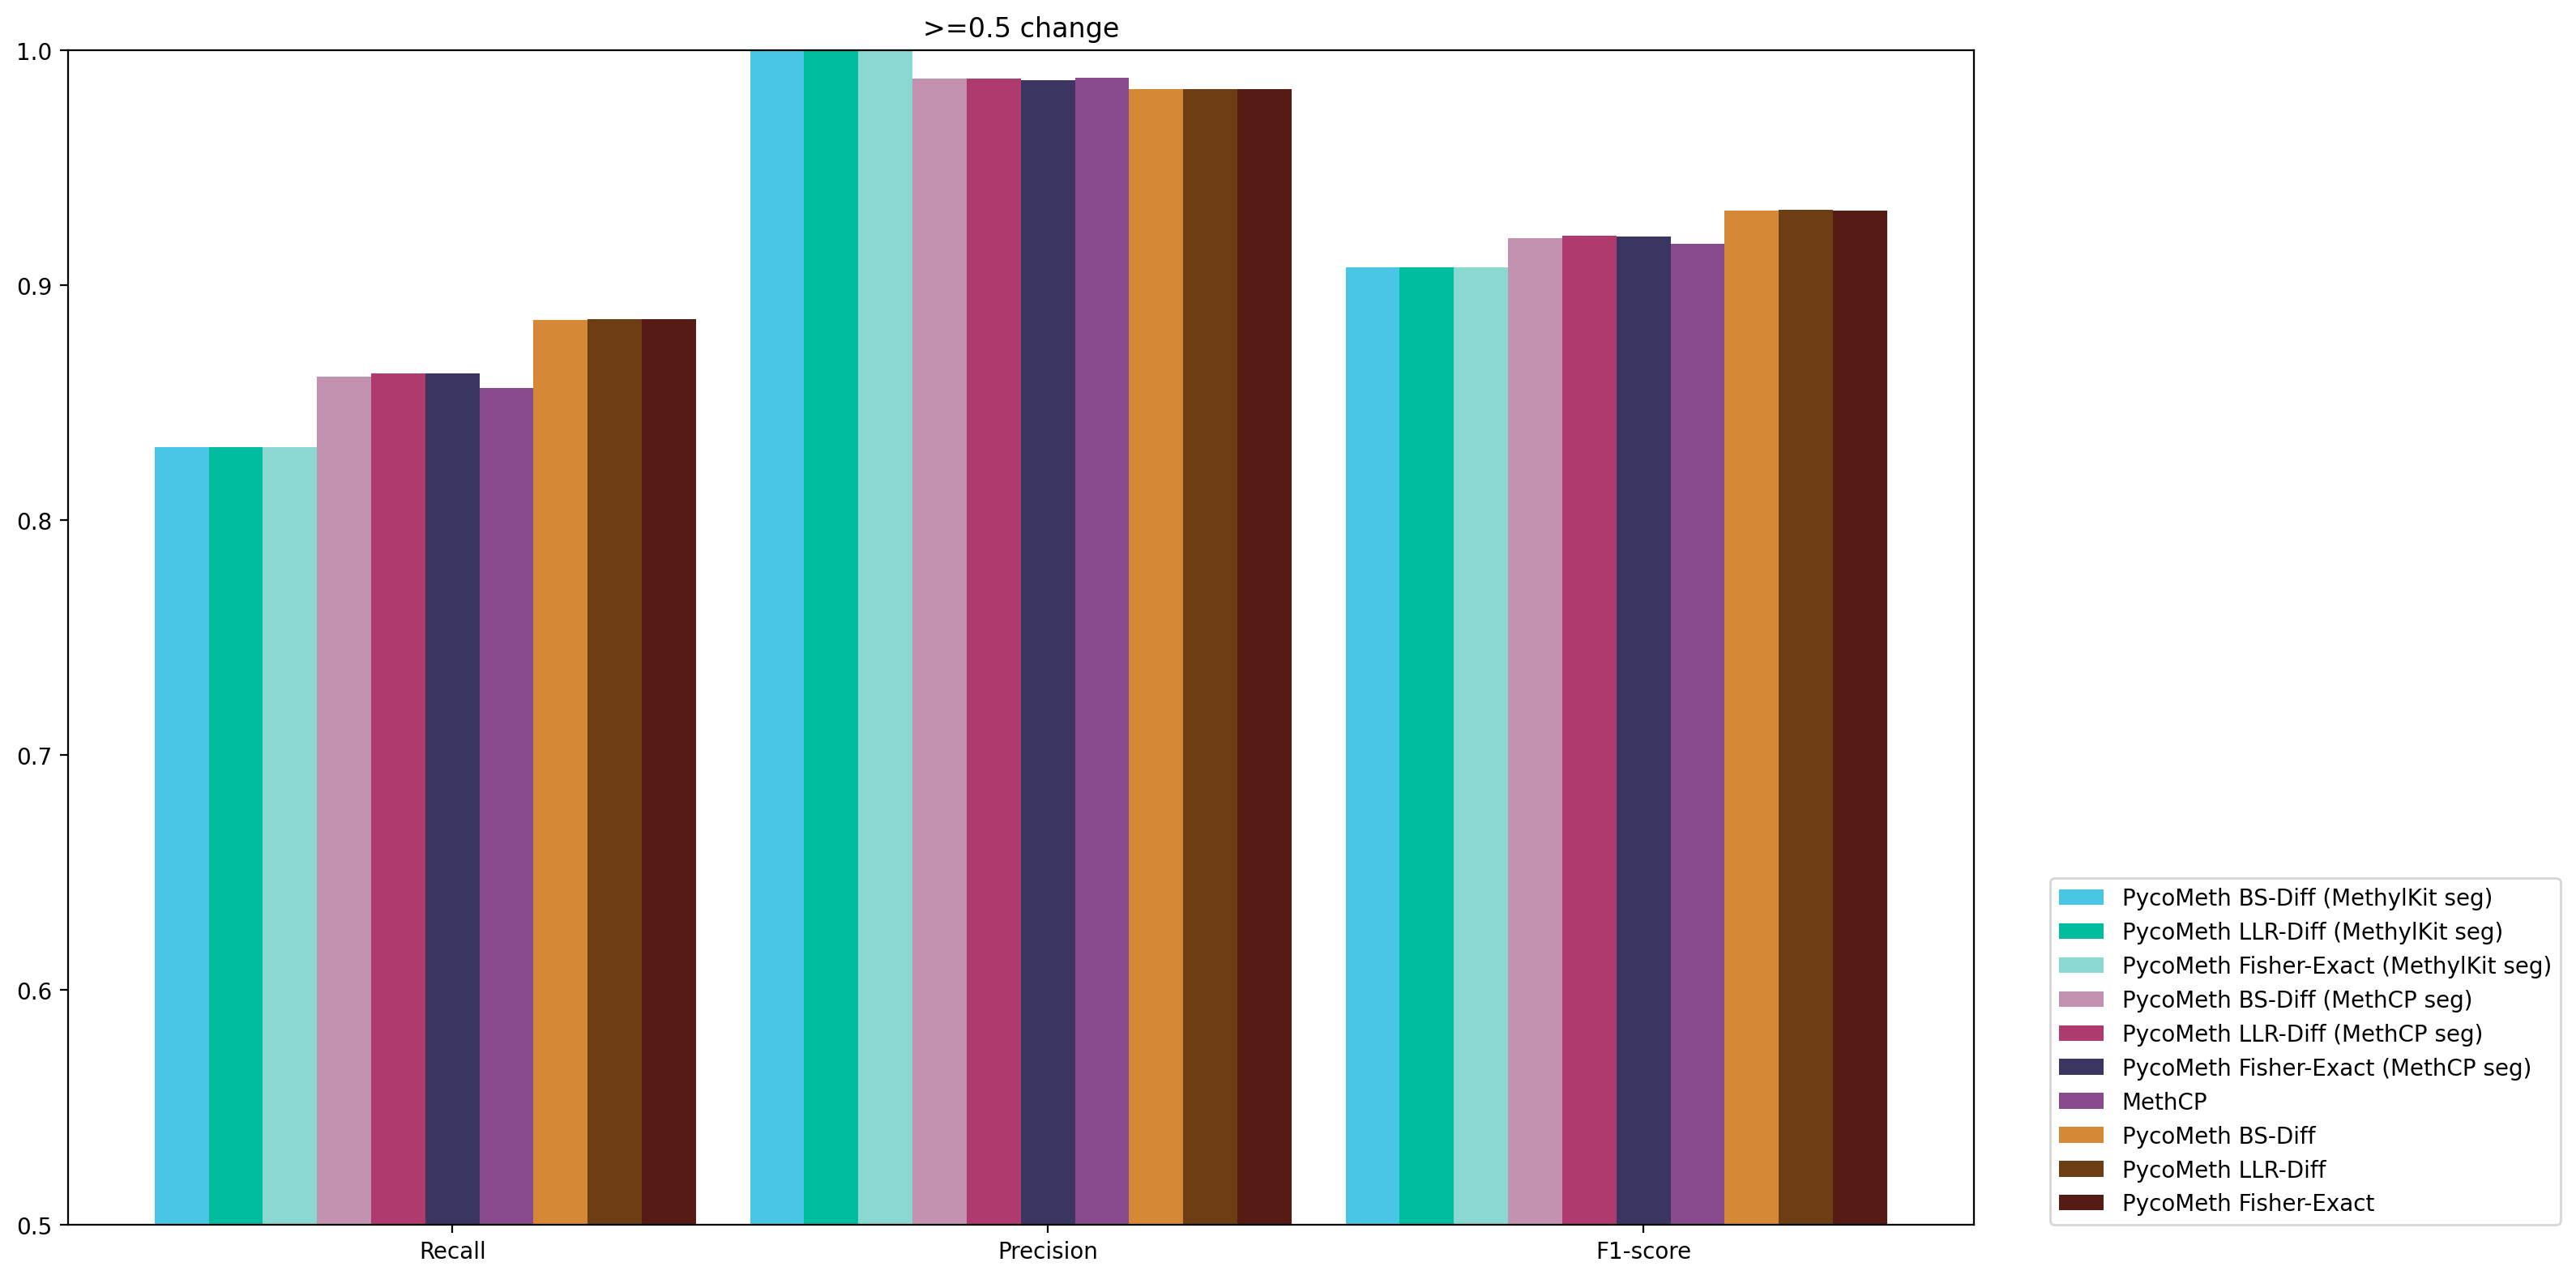

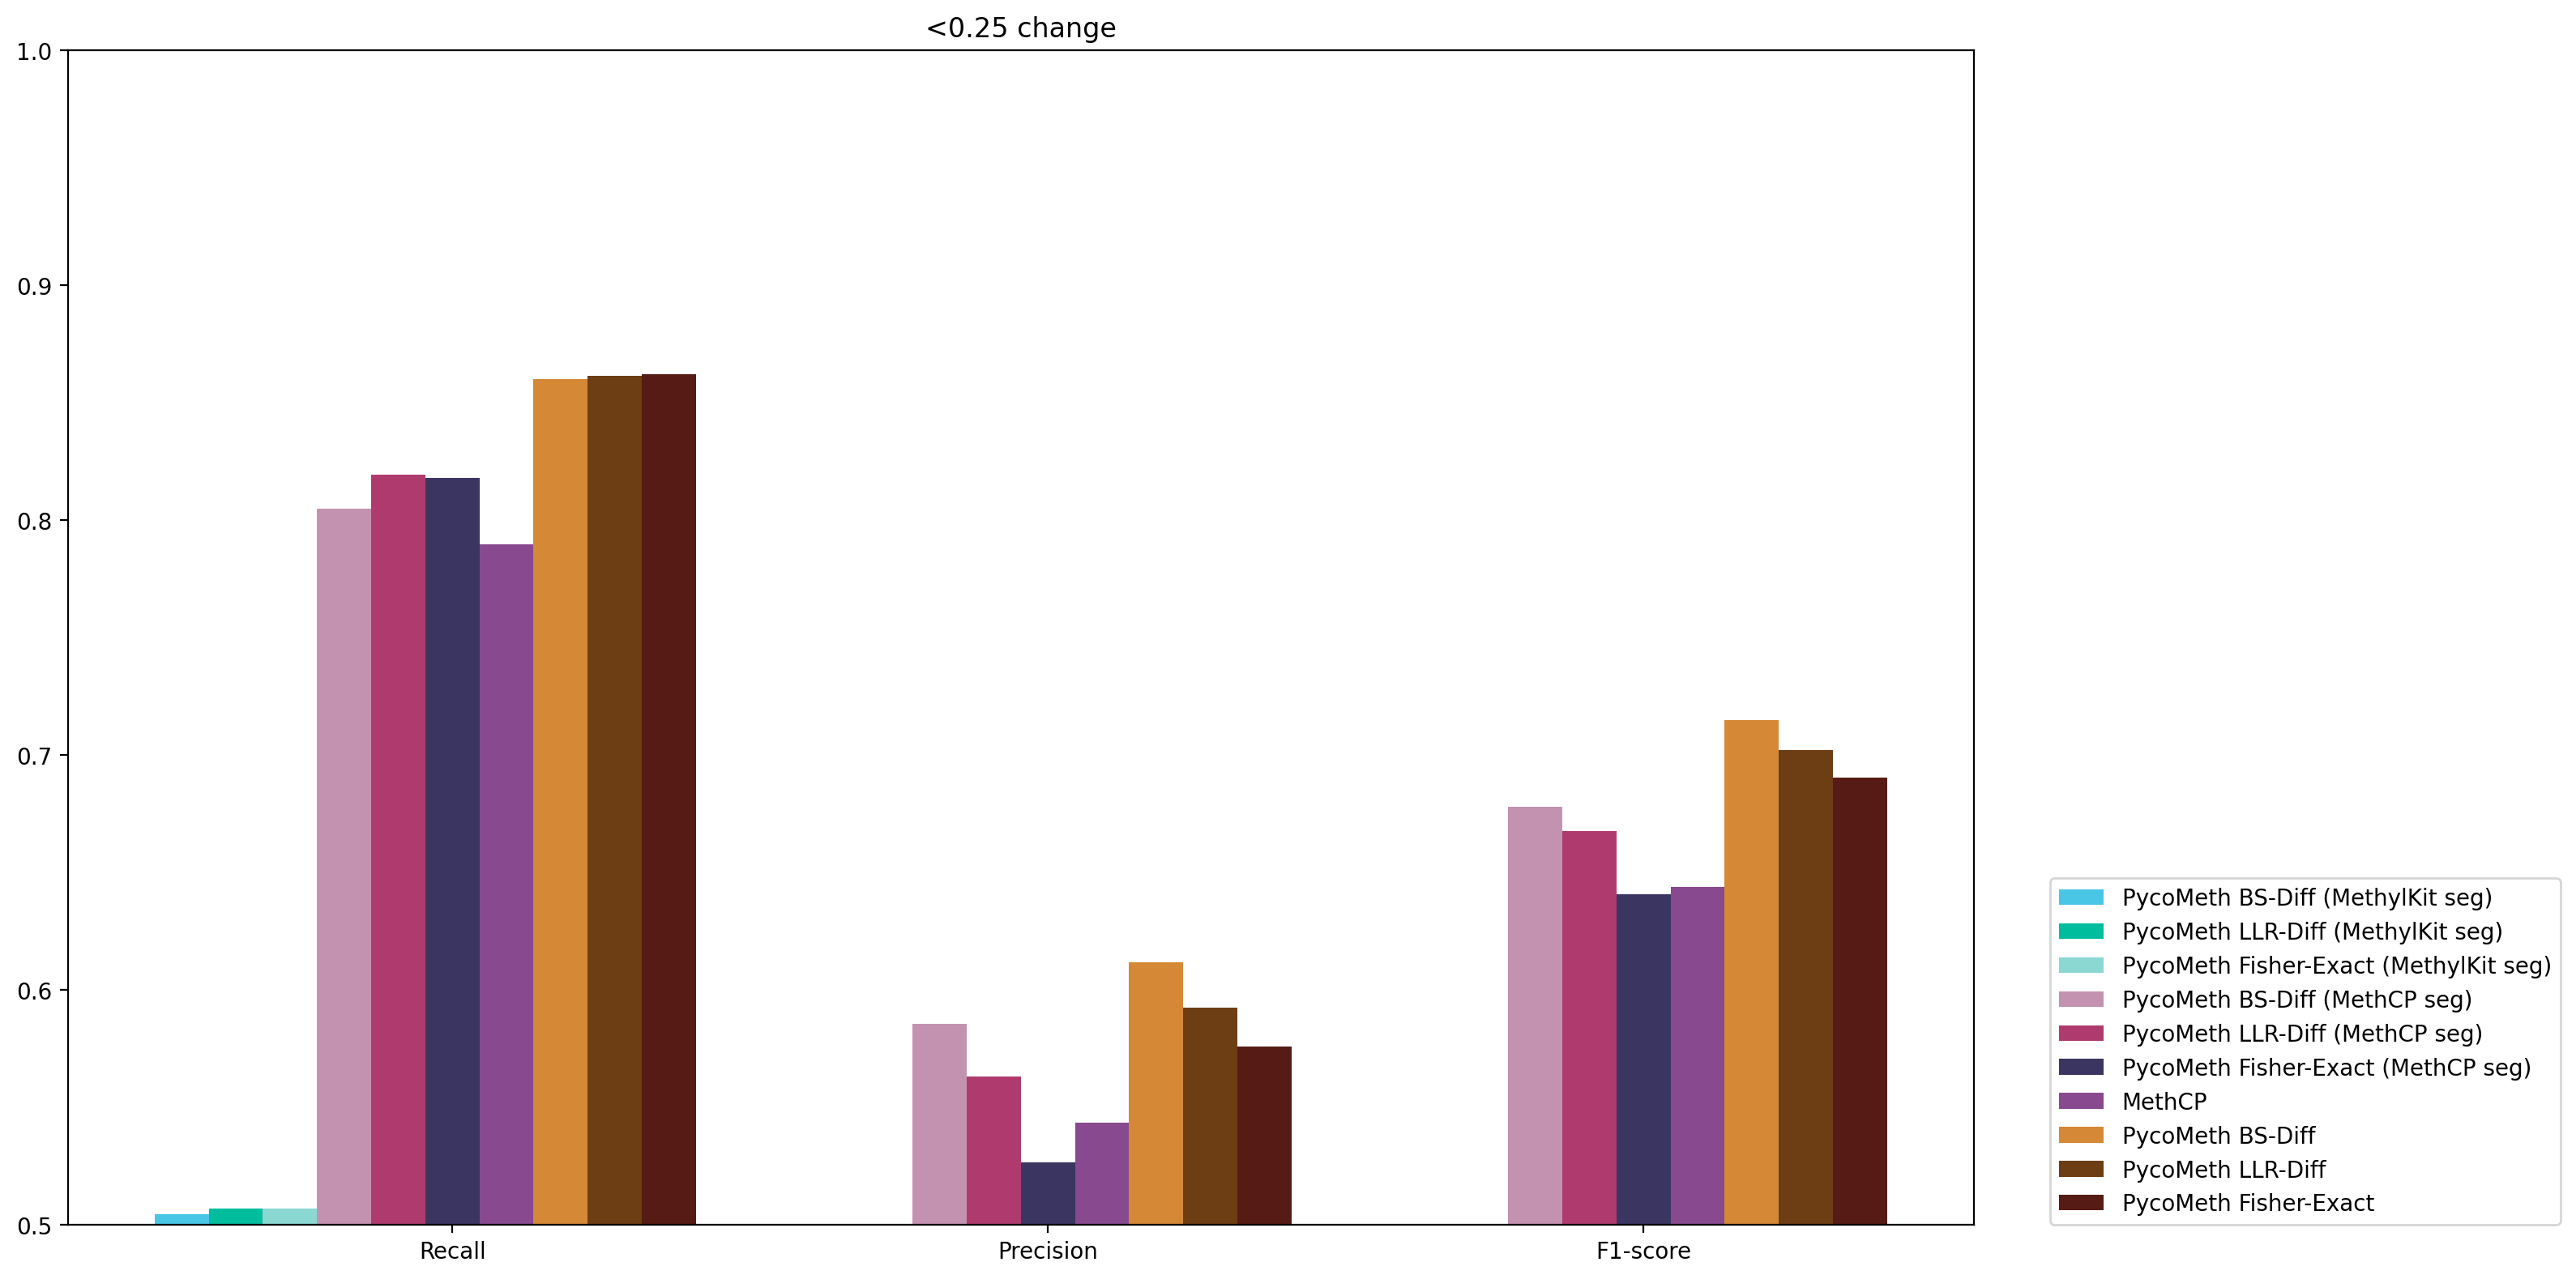

In [13]:
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all")
plot_measures(gt.loc[gt["segment_type"]==3].copy(), "Fuzzy segments", "roc_fuzzy")
plot_measures(gt.loc[gt["segment_type"]==2].copy(), "Methylated segments", "roc_methylated")
plot_measures(gt.loc[gt["segment_type"]==1].copy(), "Unmethylated segments", "roc_unmethylated")
plot_measures(gt.loc[gt["segment_type"]!=3].copy(), "All but fuzzy segments", "roc_notfuzzy")
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), ">=0.25 change", "roc_effect_size_ge0.25")
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), ">=0.5 change", "roc_effect_size_ge0.5")
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "<0.25 change", "roc_effect_size_lt0.25")

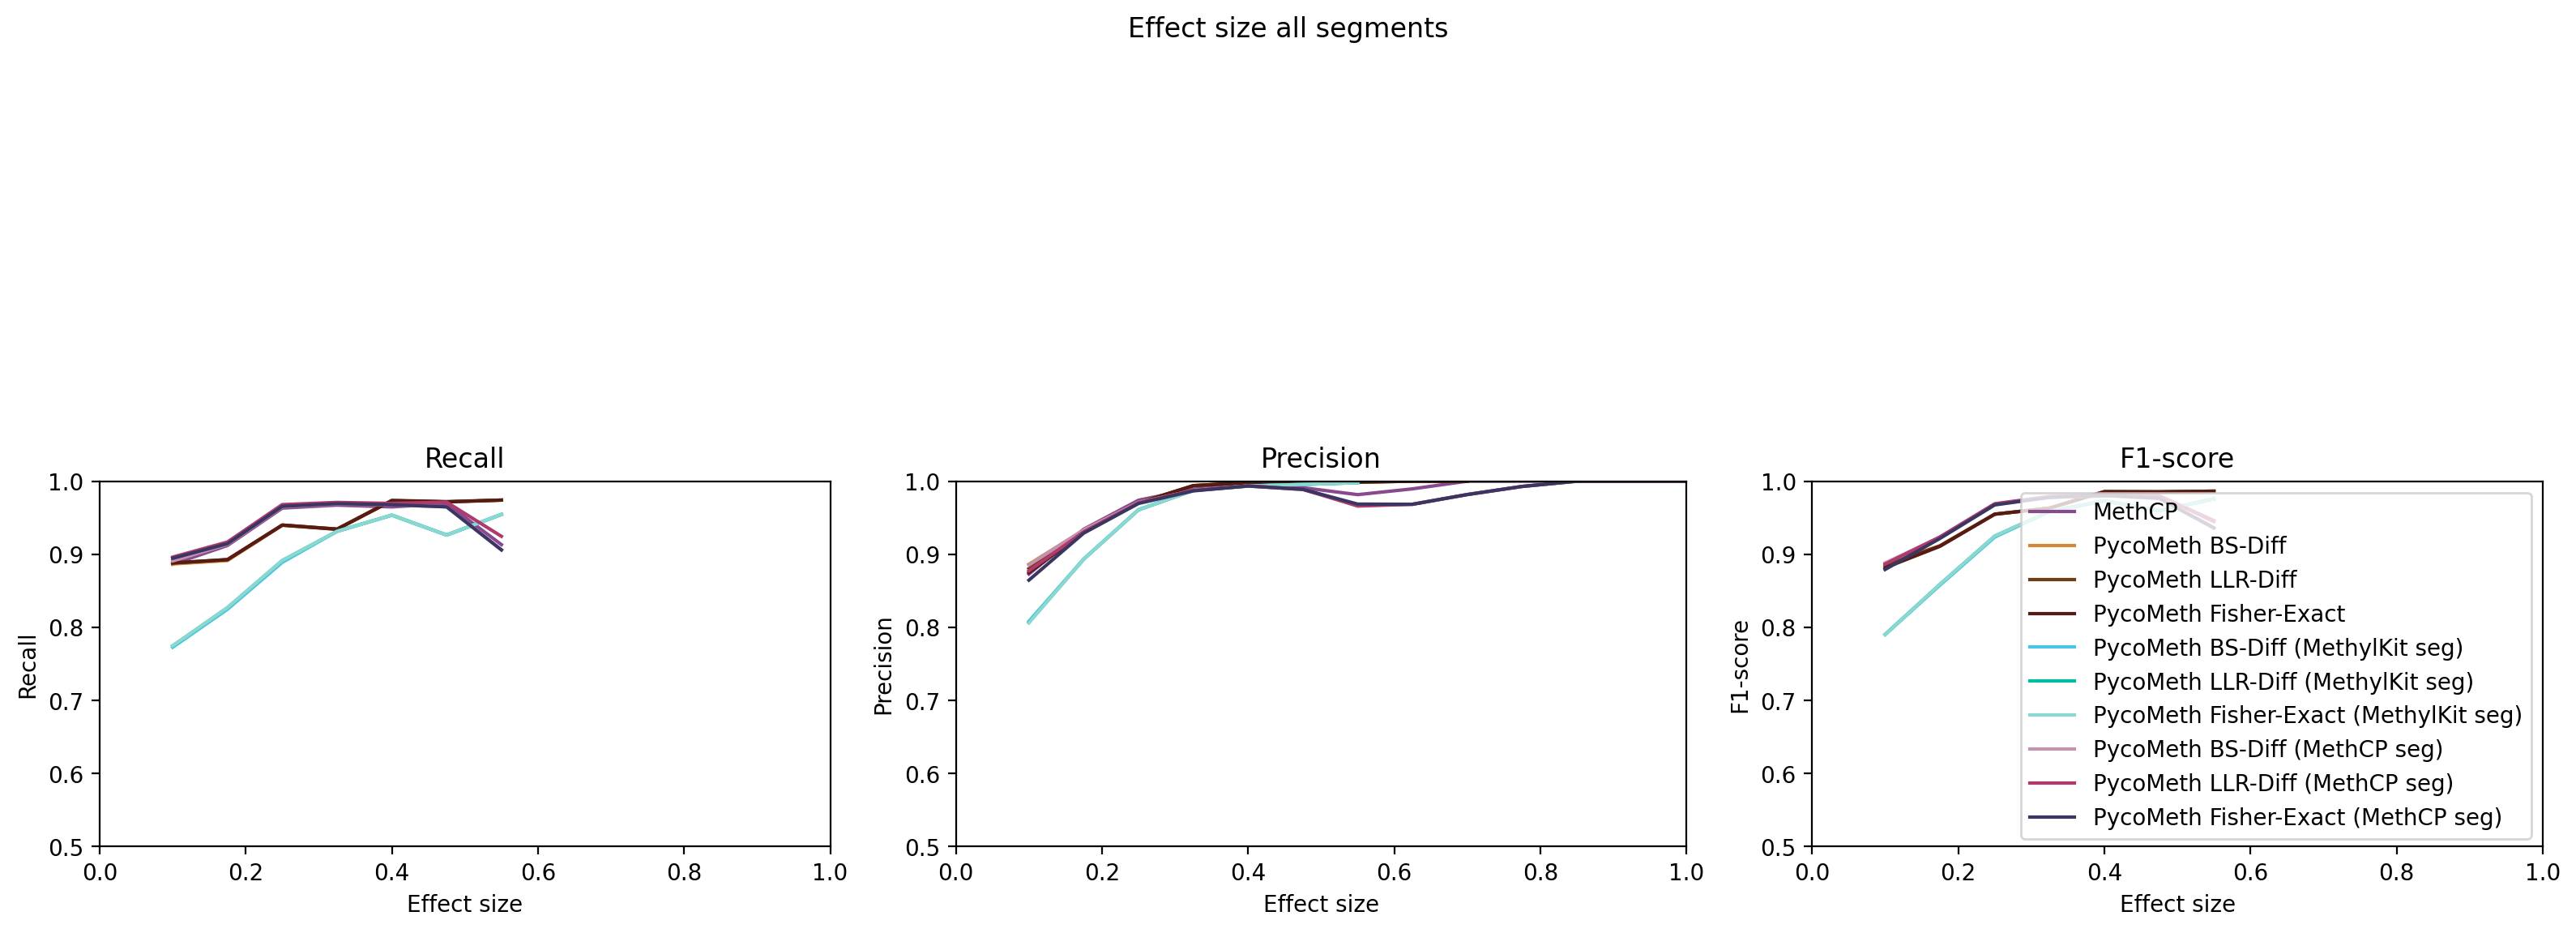

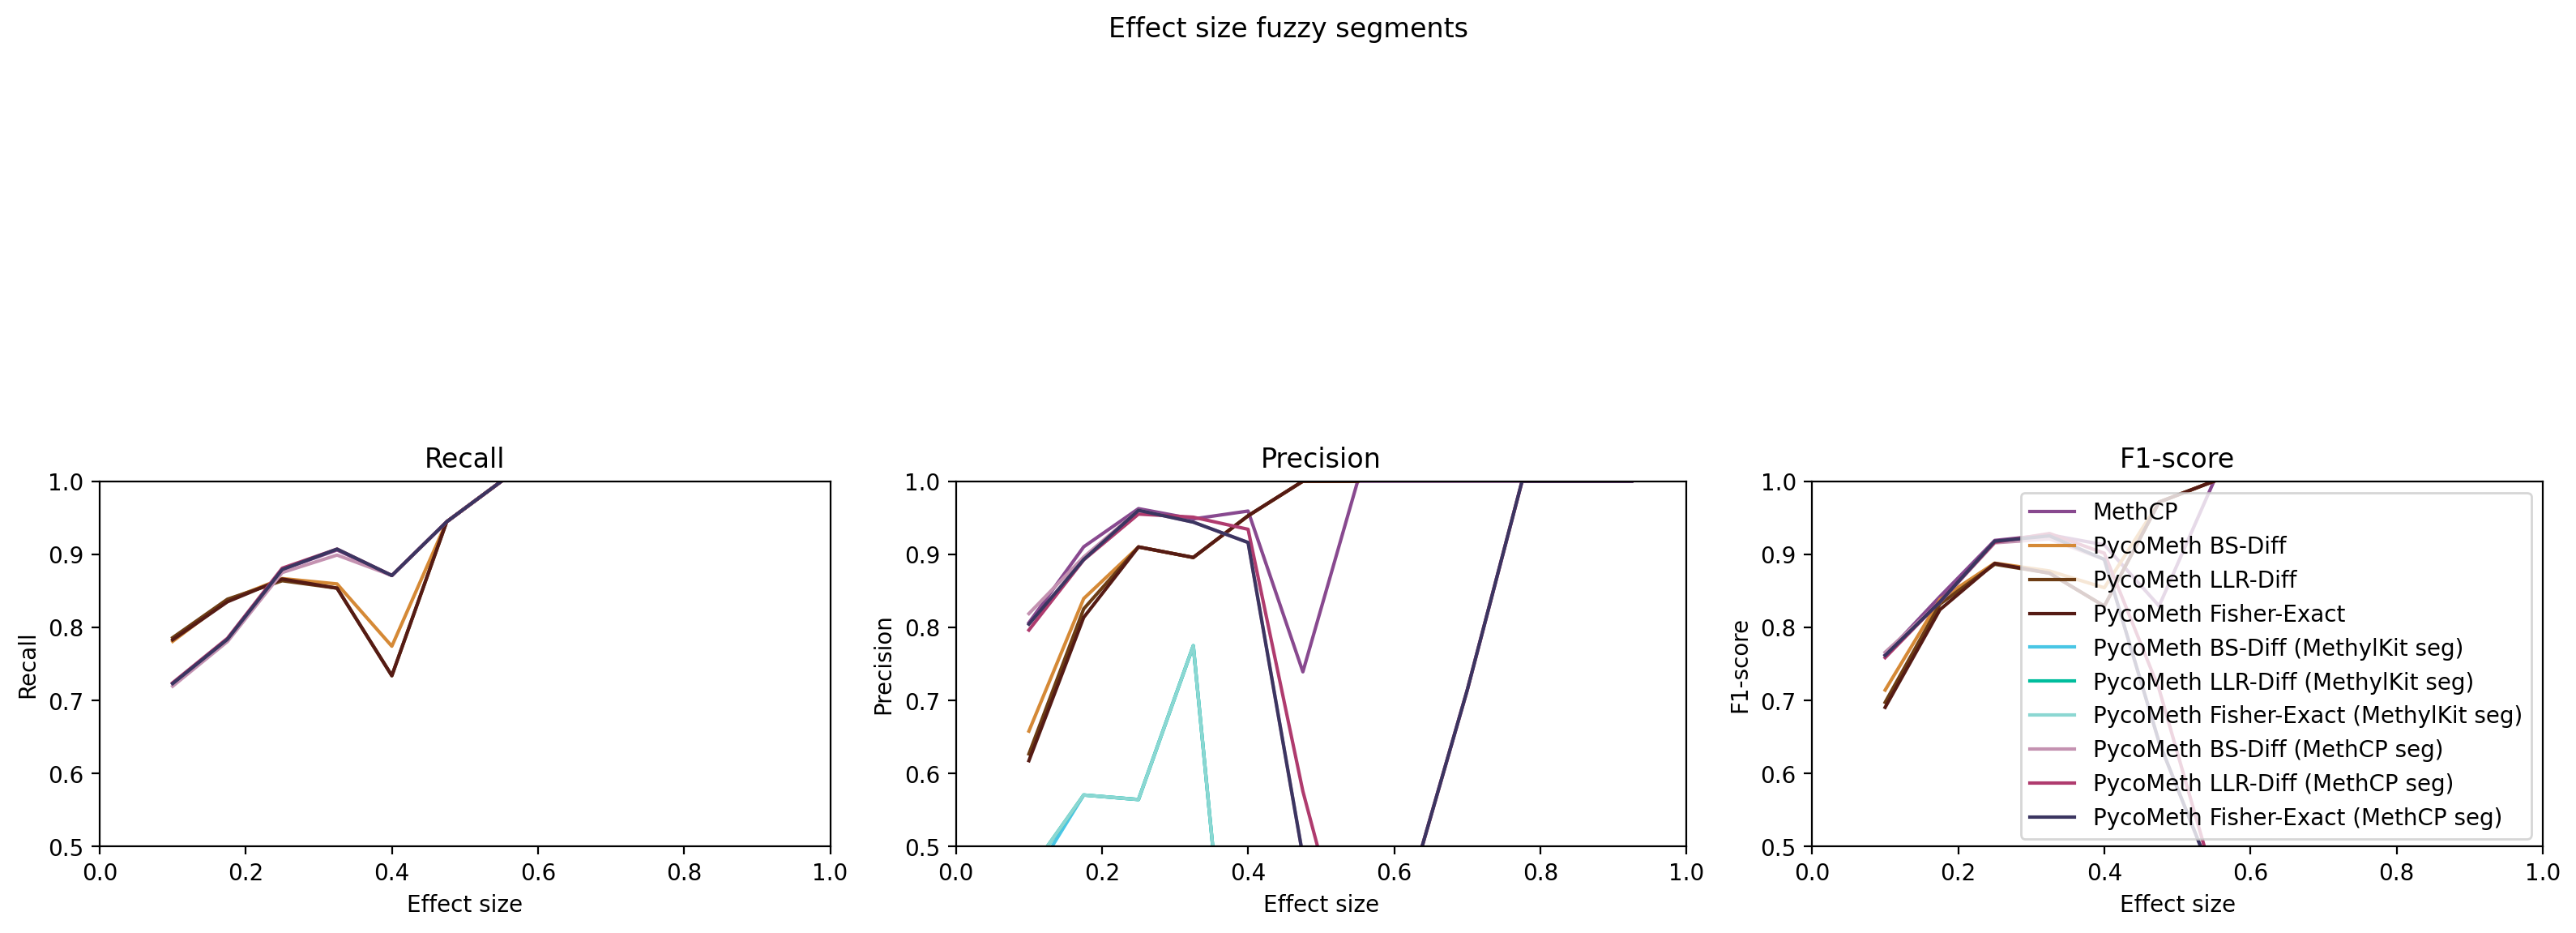

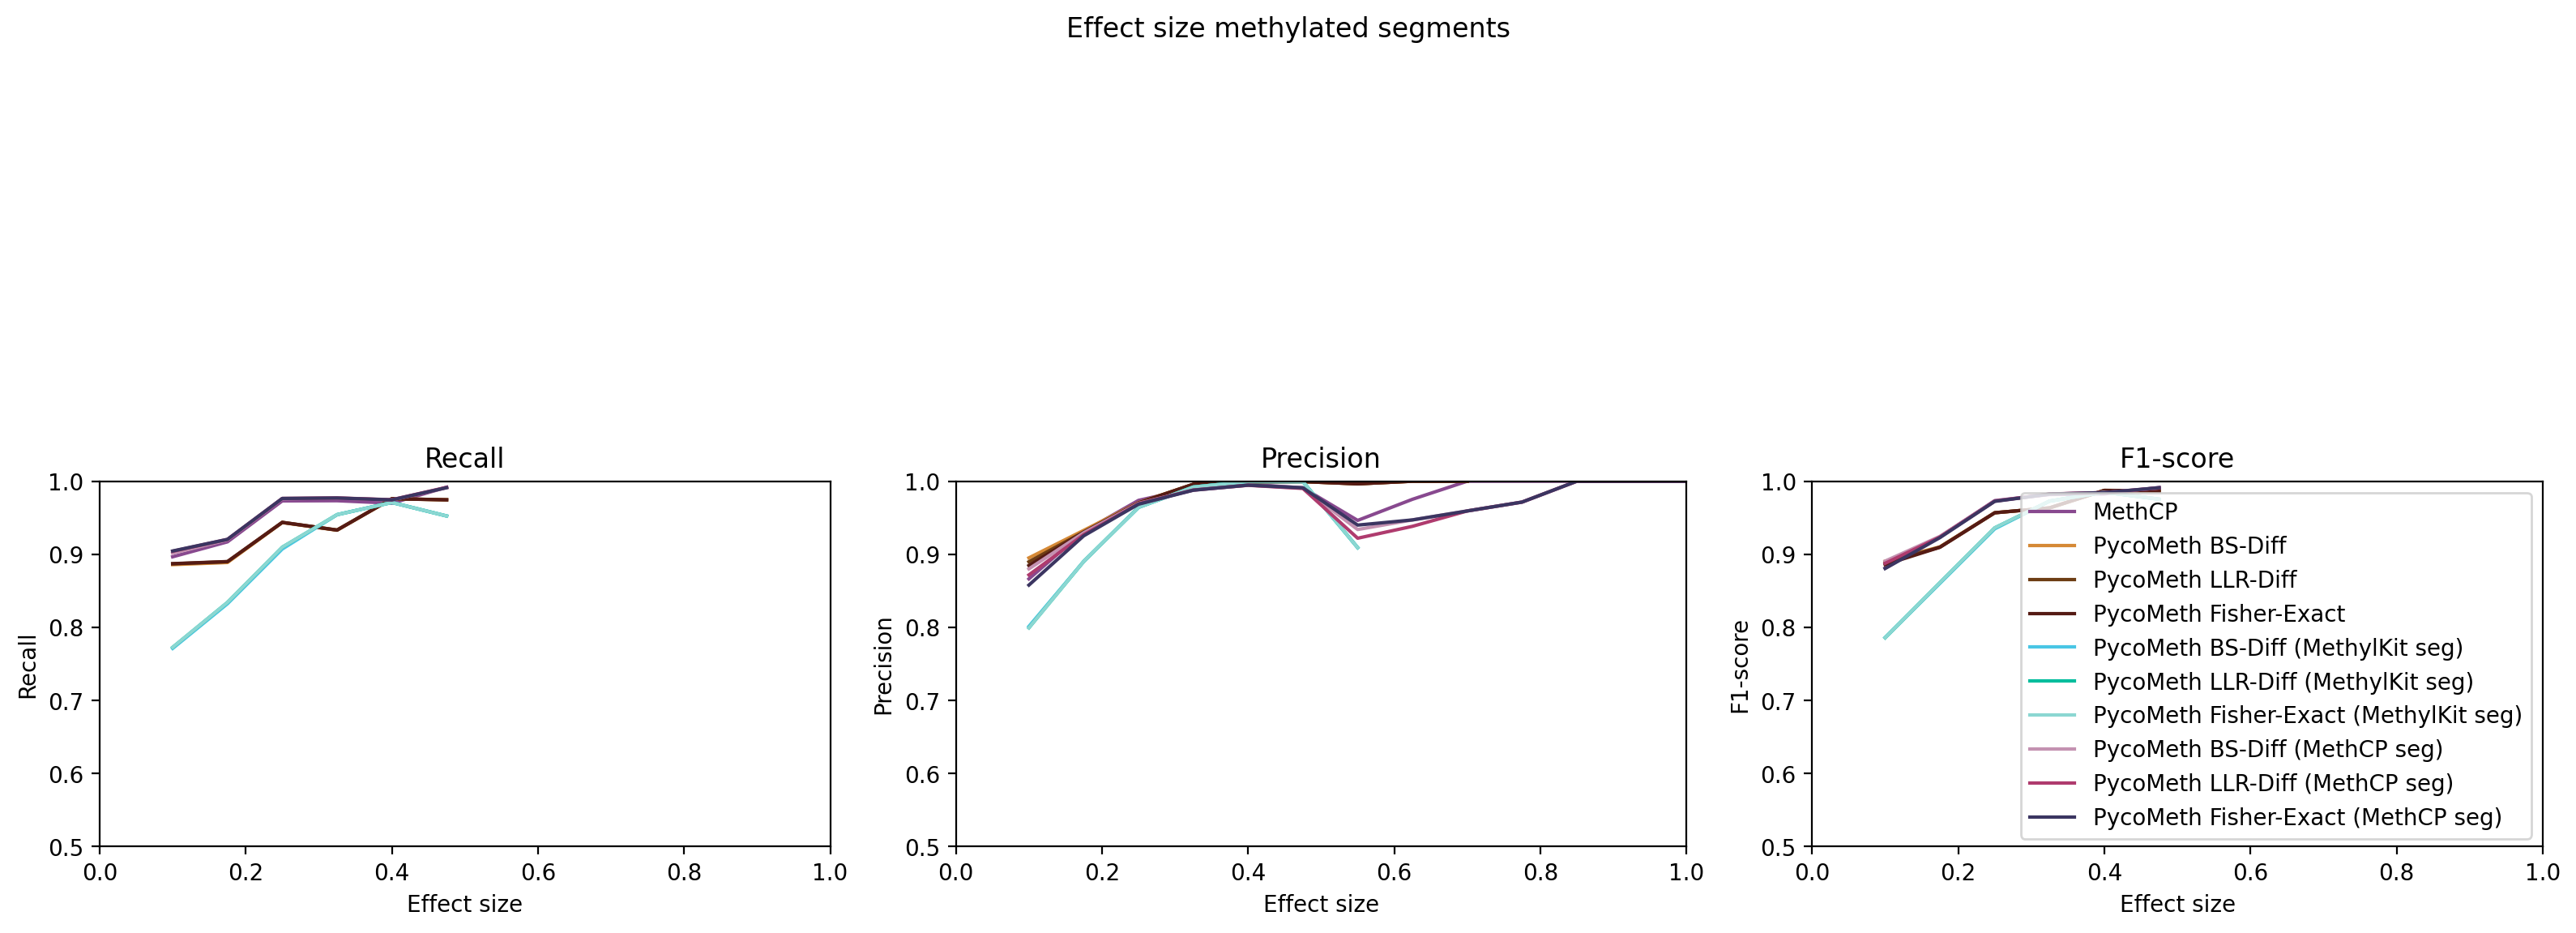

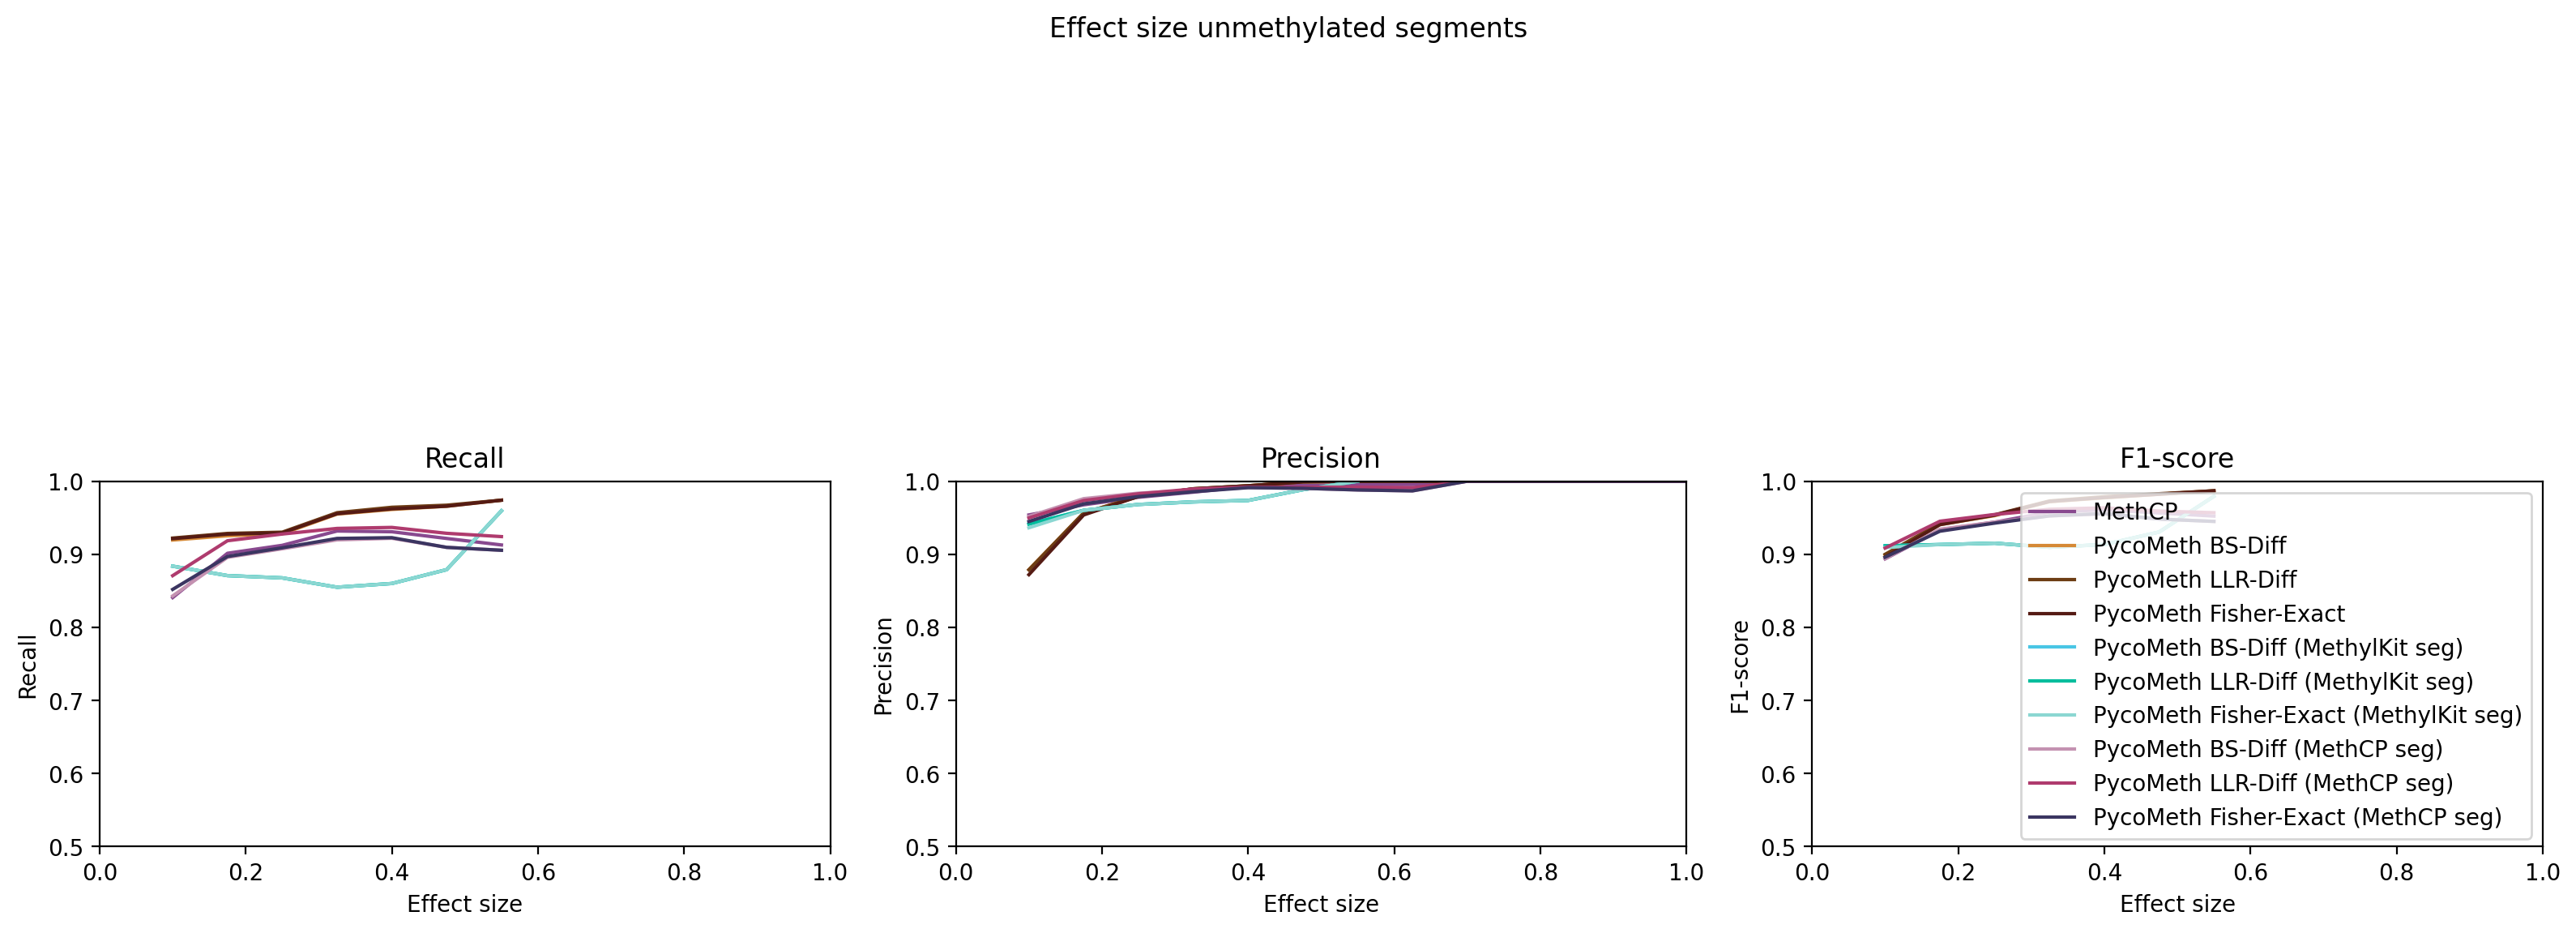

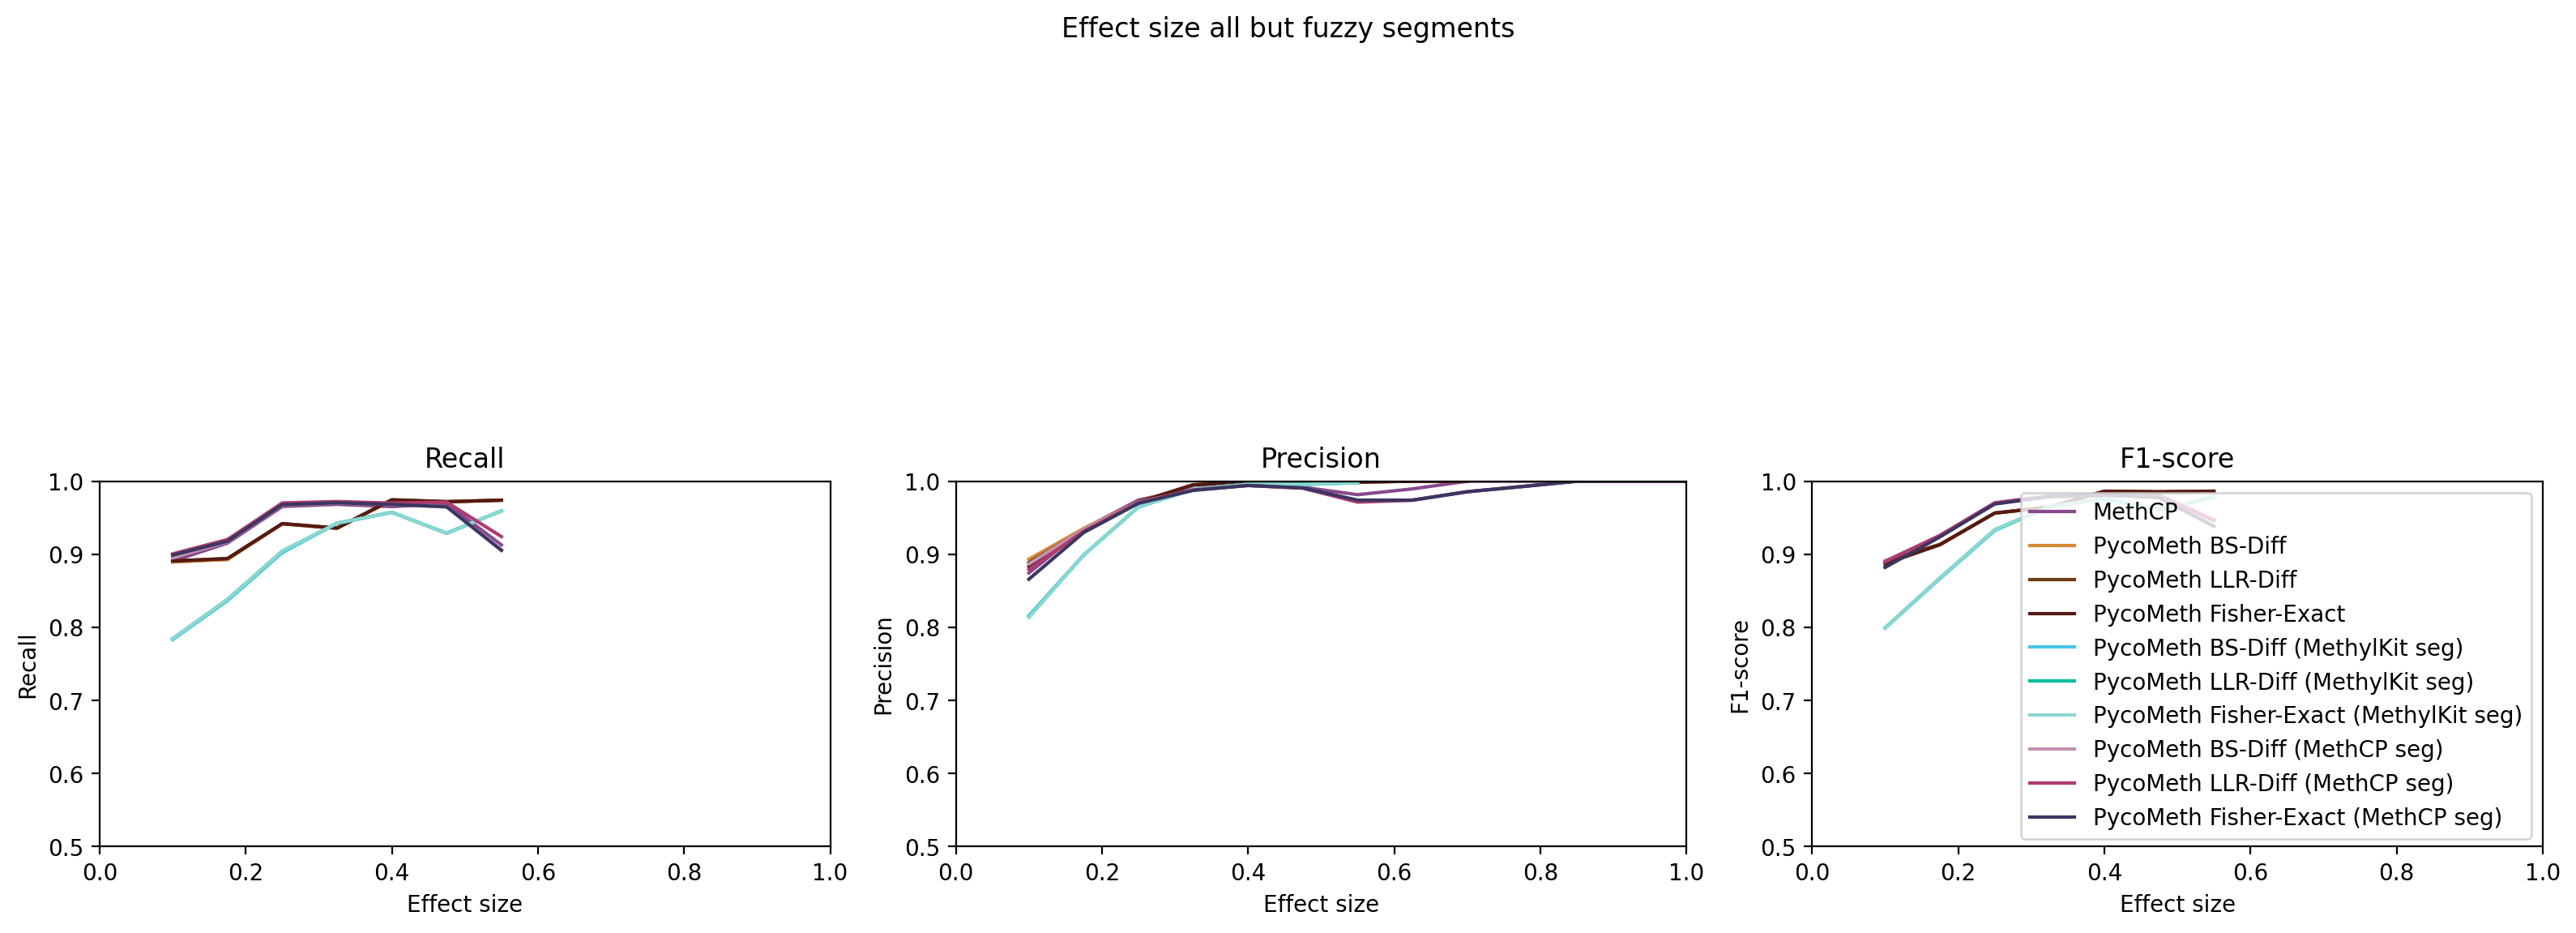

In [118]:
plot_roc_over_effect_size(gt, "Effect size all segments", "roc_effect_size_all")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==3].copy(), "Effect size fuzzy segments", "roc_fuzzy")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==2].copy(), "Effect size methylated segments", "roc_effect_size_methylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==1].copy(), "Effect size unmethylated segments", "roc_effect_size_unmethylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]!=3].copy(), "Effect size all but fuzzy segments", "roc_effect_size_notfuzzy")

In [61]:

filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [ ]:
rc.compute_discovery_counts("GT", "PycoMeth", diffmet_threshold=0.6)

In [ ]:
rc.compute_discovery_counts("GT", "PycoMeth", theta_threshold=0.6)

In [62]:
tool = "PycoMeth"
thresholds = np.arange(0.1, 0.65, 0.05)
fdrs = np.zeros((len(thresholds), len(thresholds)))
for x, tt in enumerate(tqdm.tqdm(thresholds)):
    for y, dt in enumerate(thresholds):
        tp, fp = rc.compute_discovery_counts("GT", tool, theta_threshold=tt, diffmet_threshold=dt)
        if tp+fp == 0:
            fdrs[y,x] = np.nan()
        else:
            fdrs[y,x] = fp / (fp+tp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:39<00:00,  9.01s/it]


In [26]:
filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_fisher = pycometh_fisher_dmrs.loc[pycometh_fisher_dmrs["adj_pvalue"]<0.05].copy()
rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr, "PycoMeth FE":filtered_pycometh_fisher})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [27]:
for tool in rc.segments:
    print(tool)
    print(rc.compute_tpr("GT", tool), rc.compute_precision("GT", tool))

GT
1.0 0.9852266080575692
MethCP
0.8864272157307211 0.8729680648447535
PycoMeth
0.886742046037186 0.8863274682394828
PycoMeth LLR
0.8881003139307913 0.8804105509086694
PycoMeth FE
0.8881722751436976 0.8749734155678435
